This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The housing data available in this project has around 80 different variables cataloguing a wide variety of attributes for real estate properties. The target variable of interest is the sales price.

First the dataset is cleaned. Then variables are summarized and plotted to understand characteristics. Finally, linear regression is compared with regularization to predict sales prices.

## 1. Load the dataset

---

**There is a file describing the columns in the dataset in the `data_description.txt` file in the same folder that contains the information on what the variables represent.**


In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score
import math 

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
house = pd.read_csv('/Users/lukejarmbruster/Desktop/DSI-SF-4-larmbruster/datasets/housing_regression/housing.csv')

In [3]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## 2. Examine the `SalePrice` variable

---

### 2.1 Plot the distribution of the `SalesPrice` variable and describe it with pandas

In [4]:
house.columns=house.columns.str.lower()

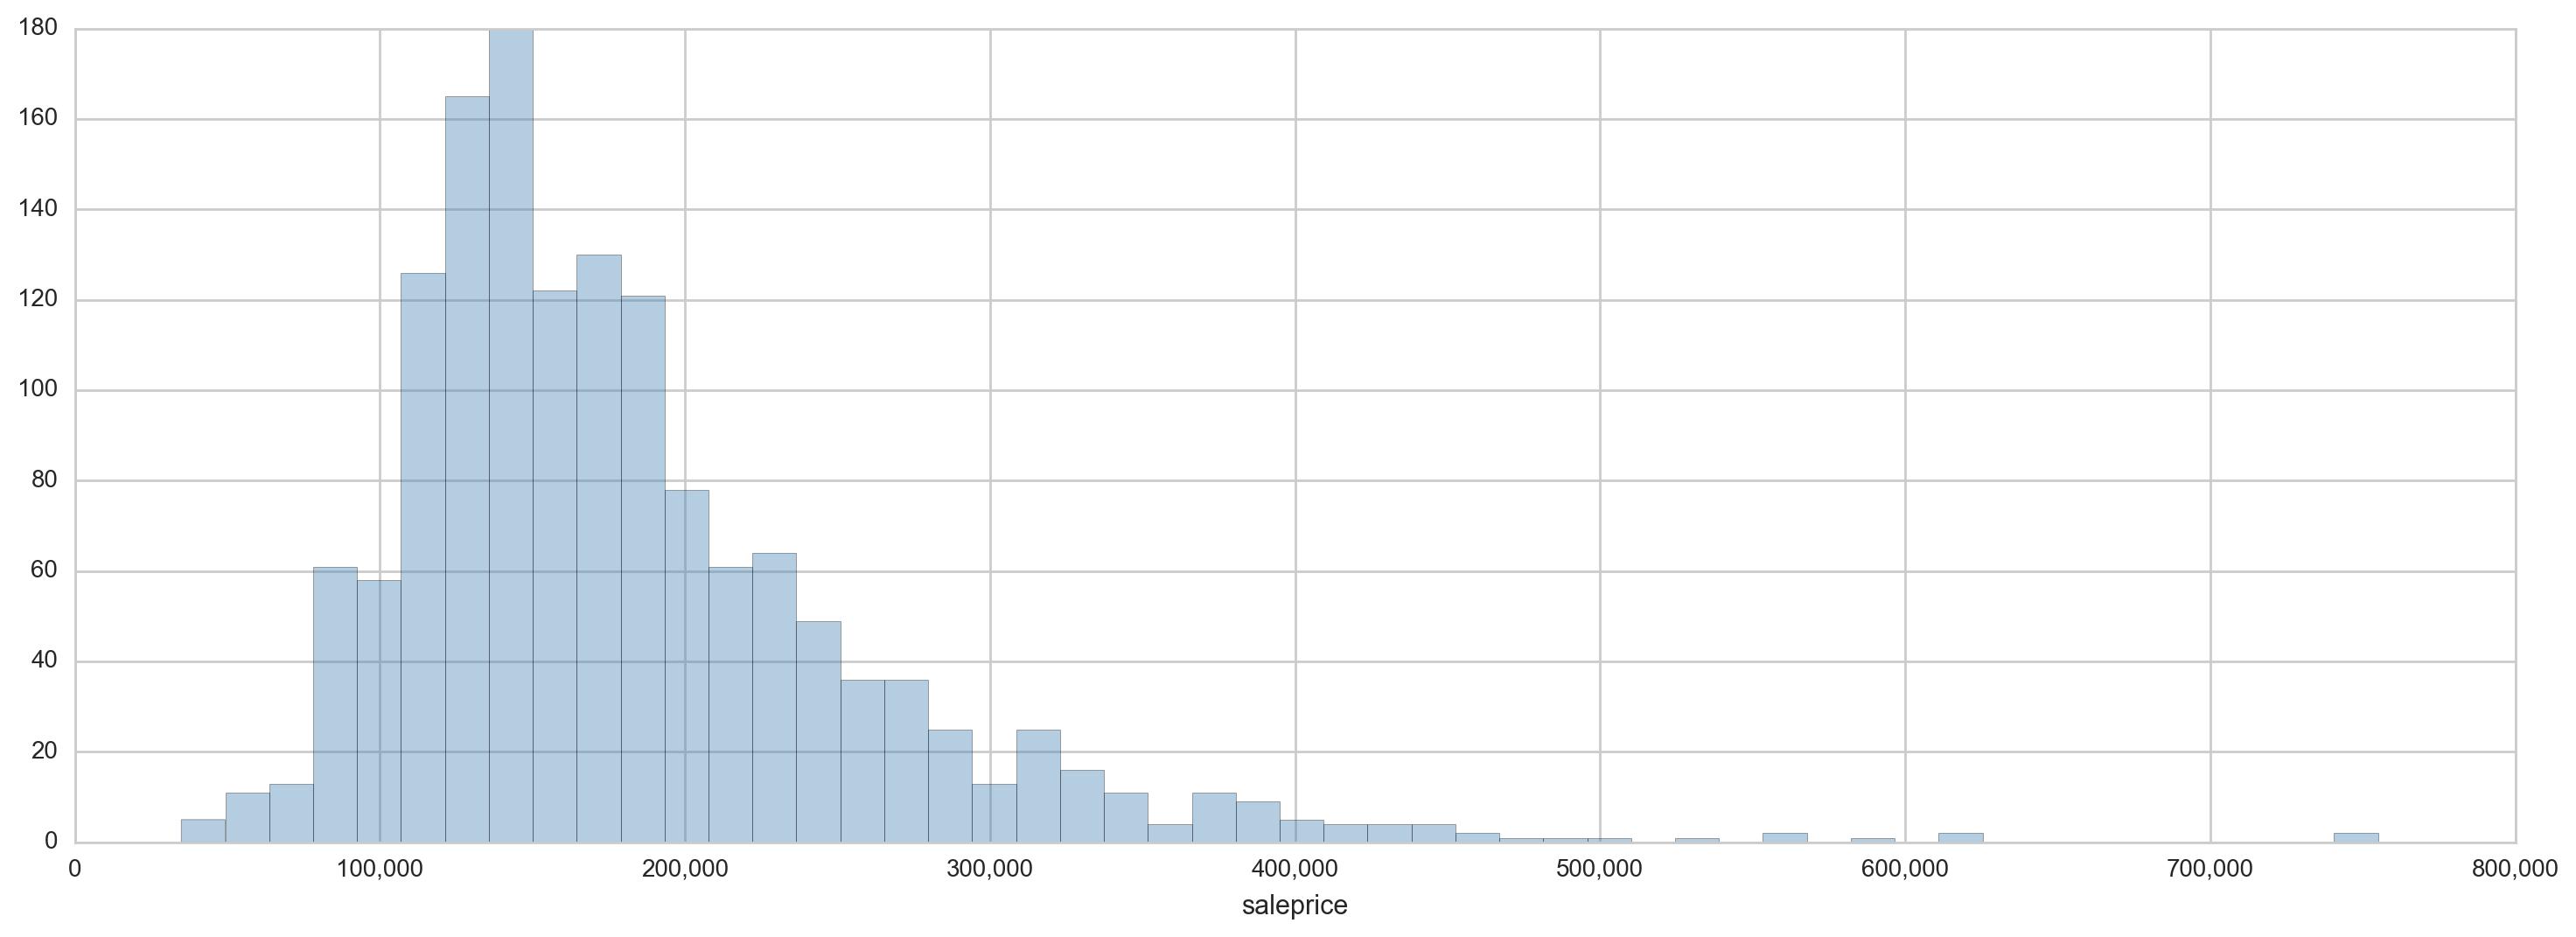

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

sns.distplot(house['saleprice'], bins=50, hist=True, kde=False, 
             color='steelblue', ax=ax)
ax.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [6]:
house['saleprice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

### 2.2 Create a transformed version of the `SalesPrice` variable that makes it more normally distributed

In [7]:
house['saleprice_log']=house['saleprice'].map(lambda x: math.log10(x))

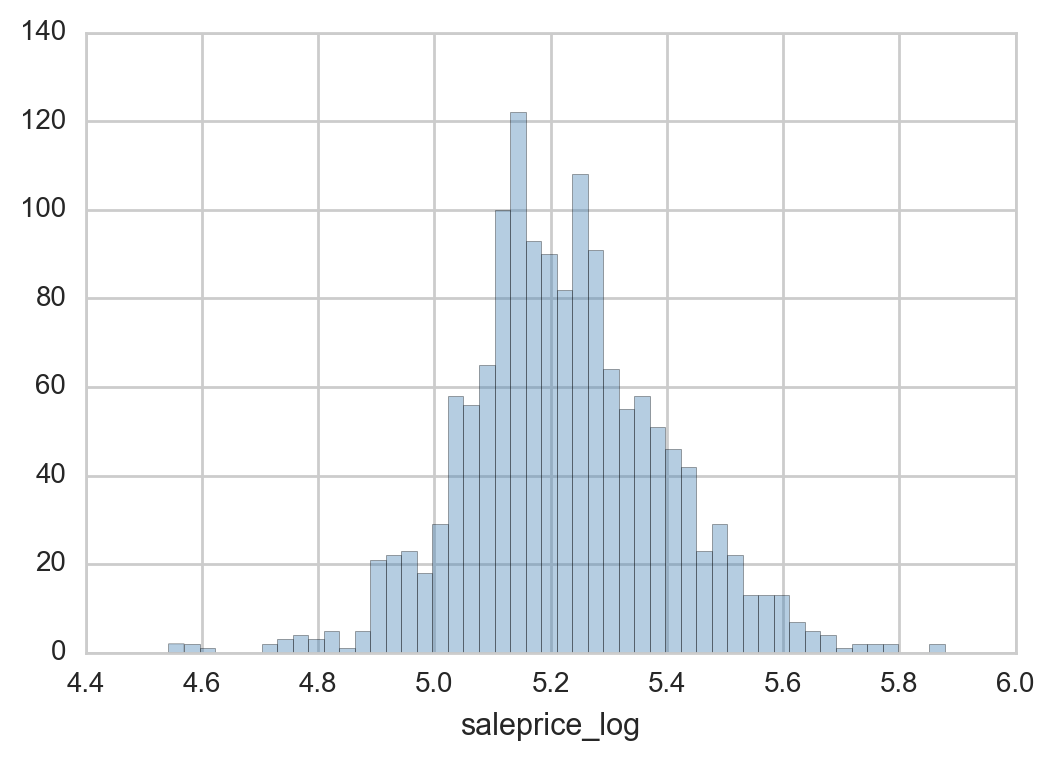

In [8]:
sns.distplot(house['saleprice_log'], bins=50, hist=True, kde=False, 
             color='steelblue')

## 3. Correlations with sale price

---

### 3.1 Correlate the age of a house when sold with the sale price

The age of the house when sold does not correlate strongly with the sale price. 

In [9]:
house['agesold']=house['yrsold']-house['yearbuilt']

In [10]:
house['agesold'].corr(house["saleprice"])

-0.52335041754681599

### 3.2 Plot the age of the house at sale against the sale price variables

Sale price and the age of the house at sale show a weak relationship. 

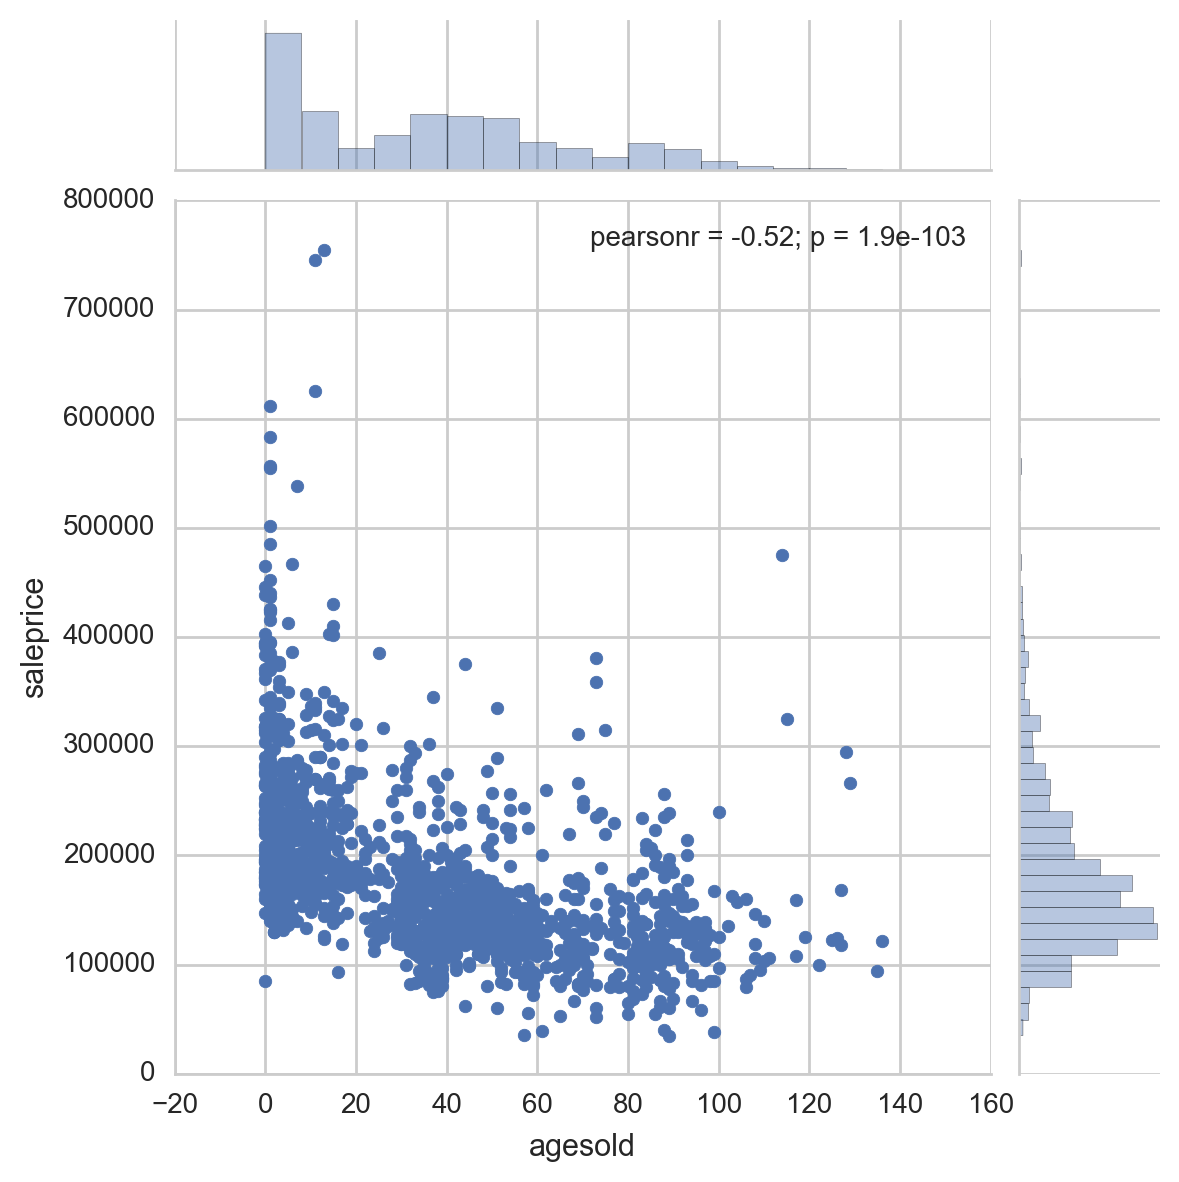

In [11]:
sns.jointplot(y=house['saleprice'], x=house['agesold'],ylim=[0,800000])

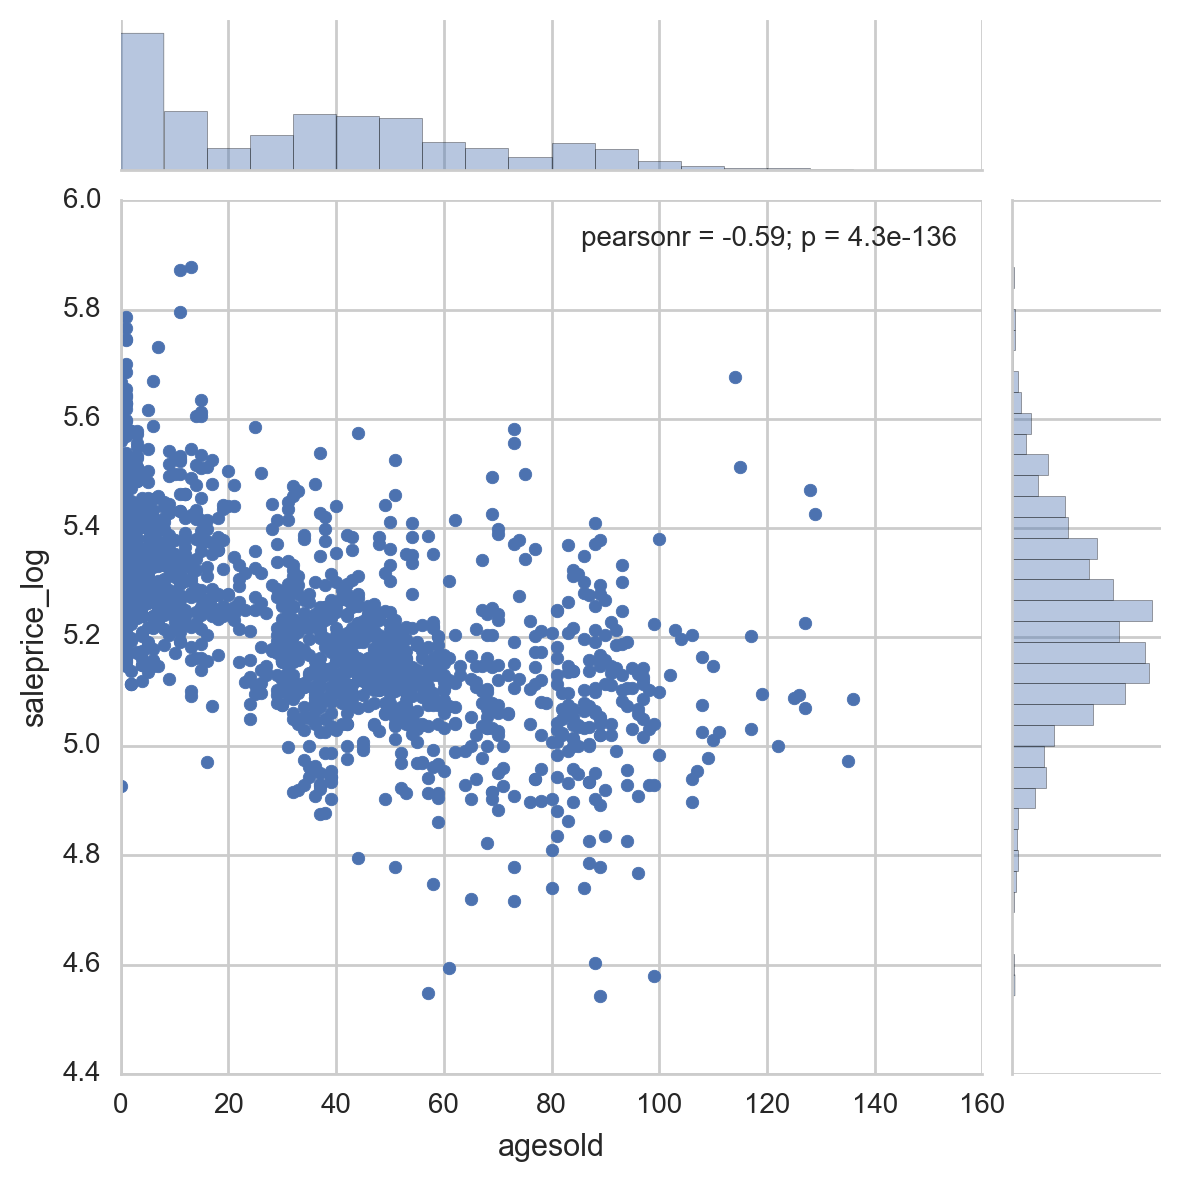

In [12]:
sns.jointplot(y=house['saleprice_log'], x=house['agesold'],xlim=[0,160])

### 3.3 Visually compare price to total livable square feet, `GrLivArea`

Based on the plot below, there is a high, positive correlation between above ground living area and sale price. In general, as the above ground living area increases, the sale price also increases.

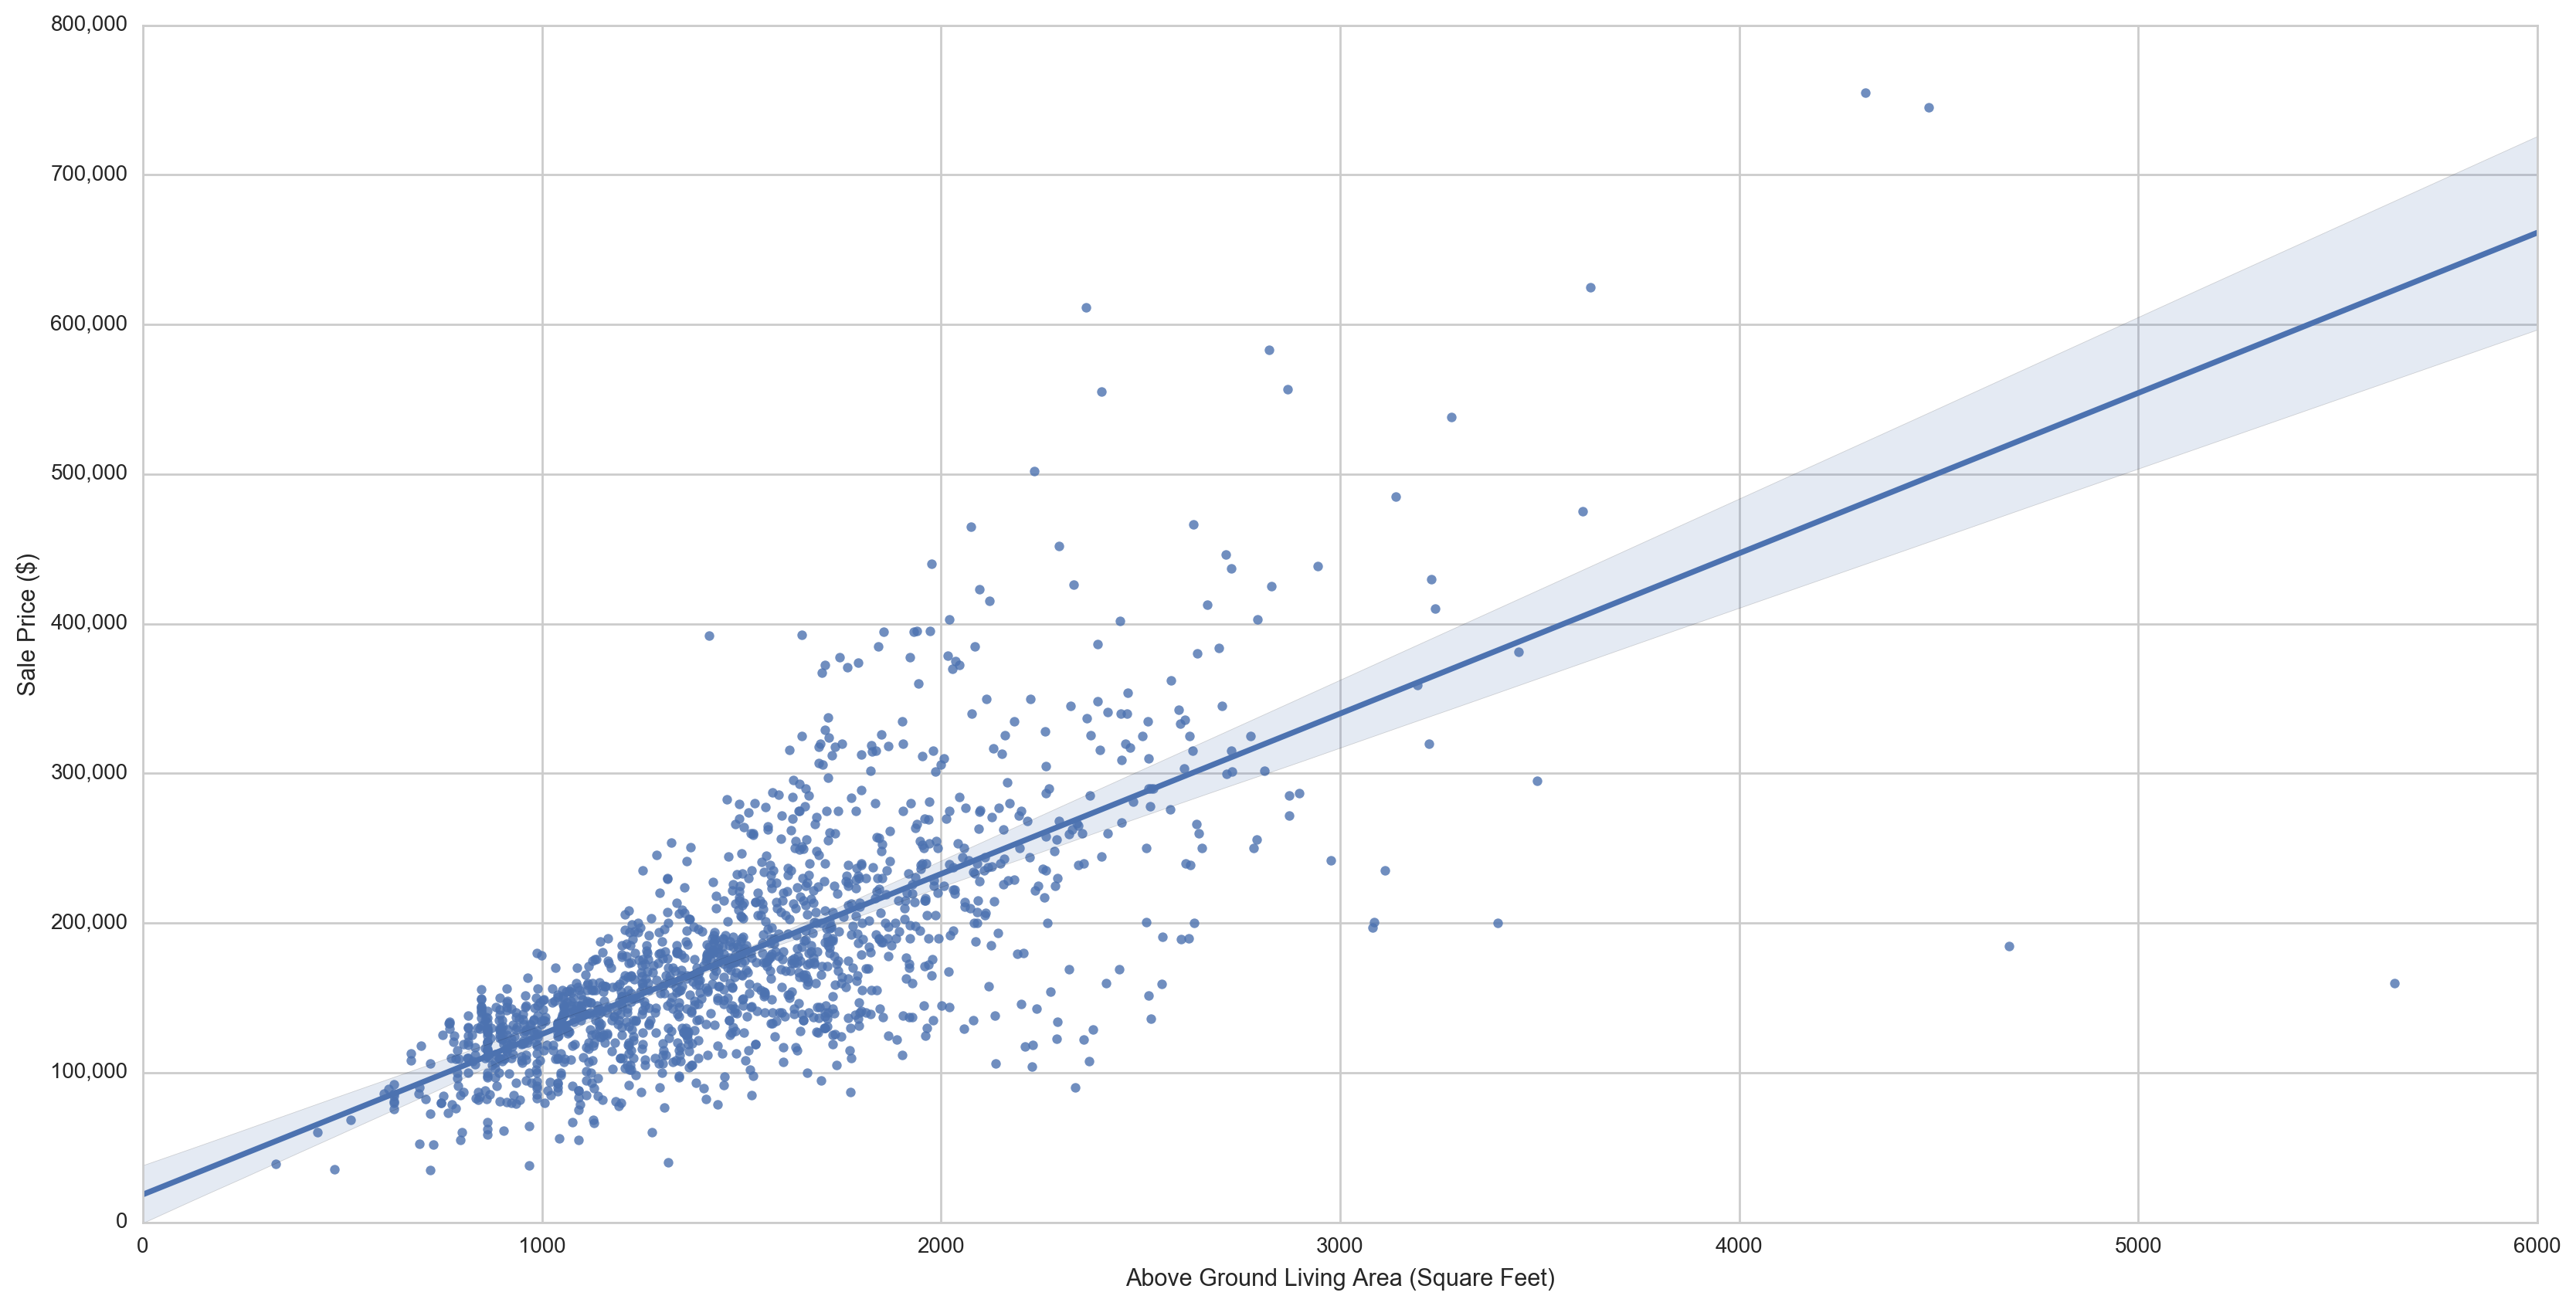

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.regplot(y=house['saleprice'], x=house['grlivarea'],ax=ax,fit_reg=True)

ax.set_xlabel('Above Ground Living Area (Square Feet)')
ax.set_ylabel('Sale Price ($)')

ax.set_ylim([0,800000])


ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))


sns.plt.show()

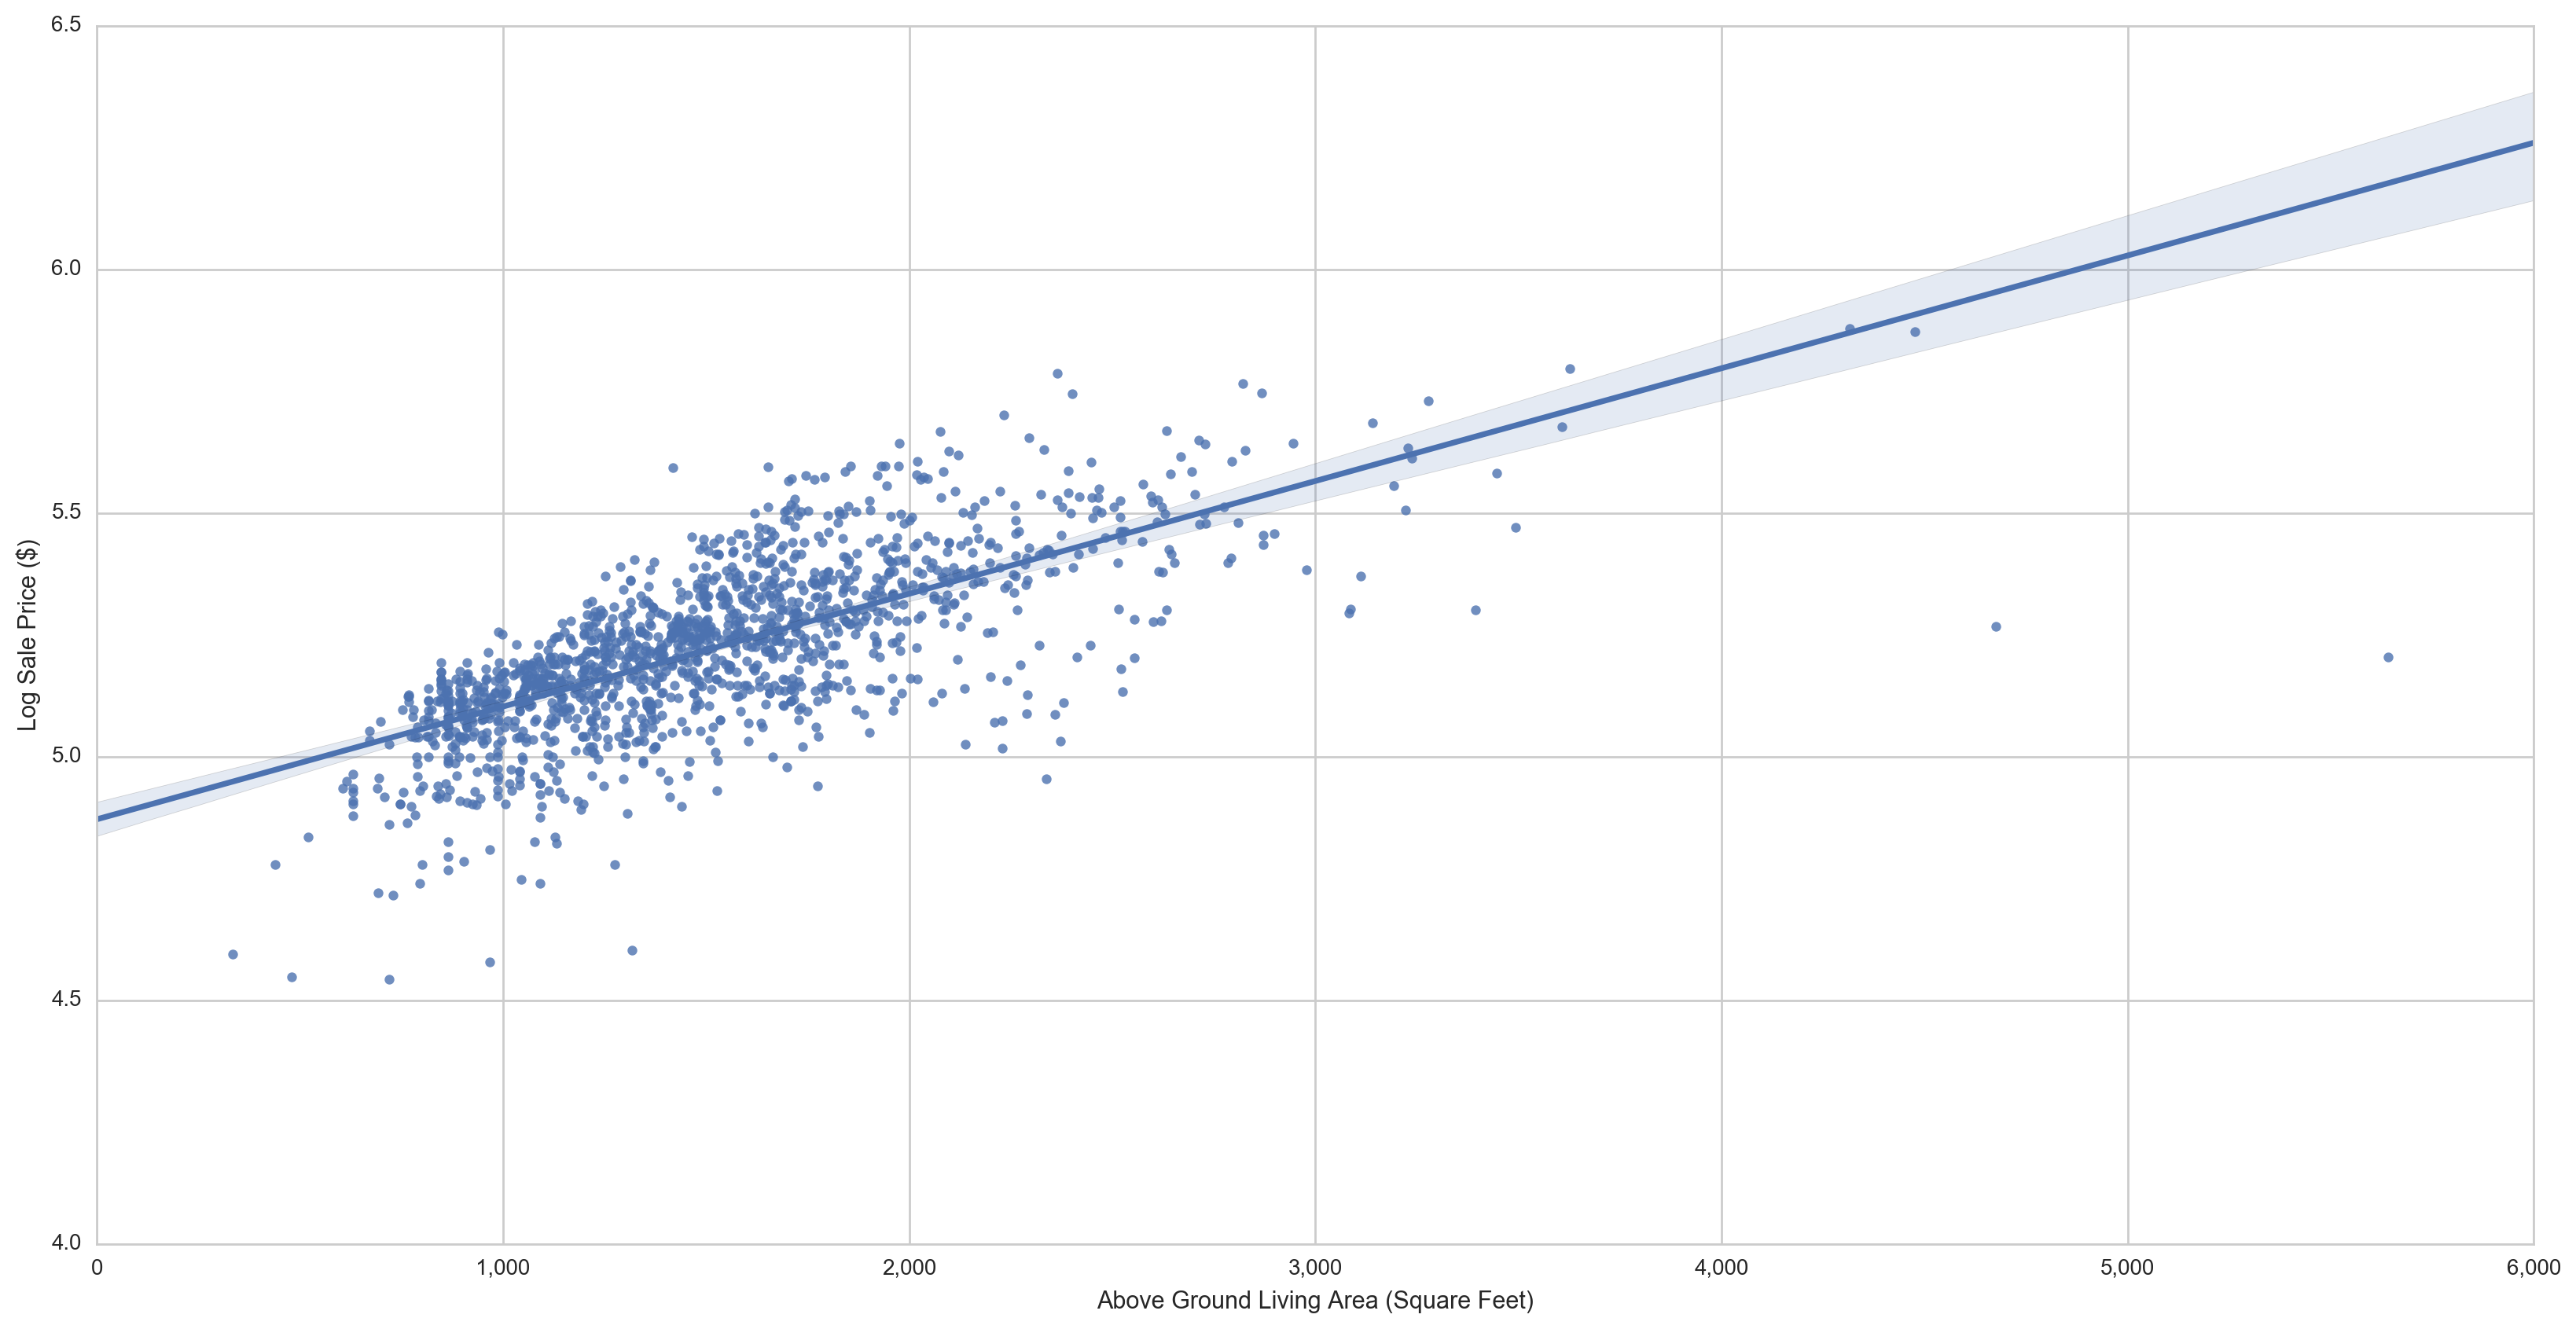

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.regplot(y=house['saleprice_log'], x=house['grlivarea'],ax=ax,fit_reg=True)

ax.set_xlabel('Above Ground Living Area (Square Feet)')
ax.set_ylabel('Log Sale Price ($)')

ax.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))


sns.plt.show()

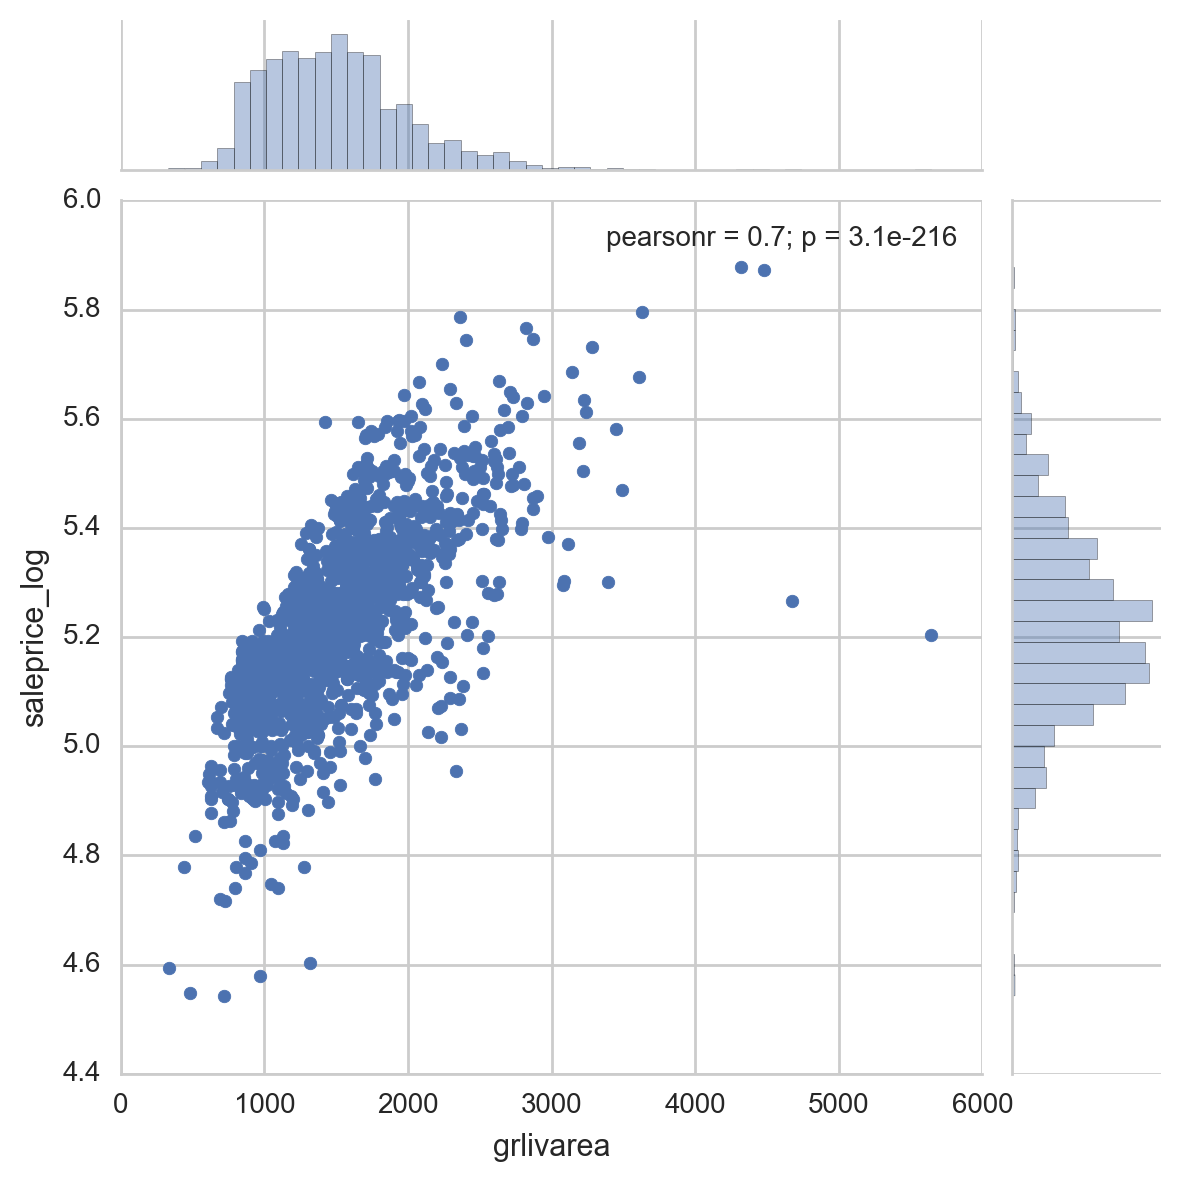

In [15]:
sns.jointplot(house.grlivarea, house.saleprice_log)

### 3.4 Plot and describe the relationship between two continuous variables

I chose two sale price variables to investigate against sale price: lot area and garage area. I am curious to see whether either would noticeably be related to sale price. I expect to see that lots with more lot area cost more. On the other hand, I don't expect garage size necessarily to be related to sale price. I think that a garage would be relatively less important than the size of the property. I am suprised to not see at least a slight relationship between lot size and sale price. Instead, I see a strong relationship between garage size and sale price.

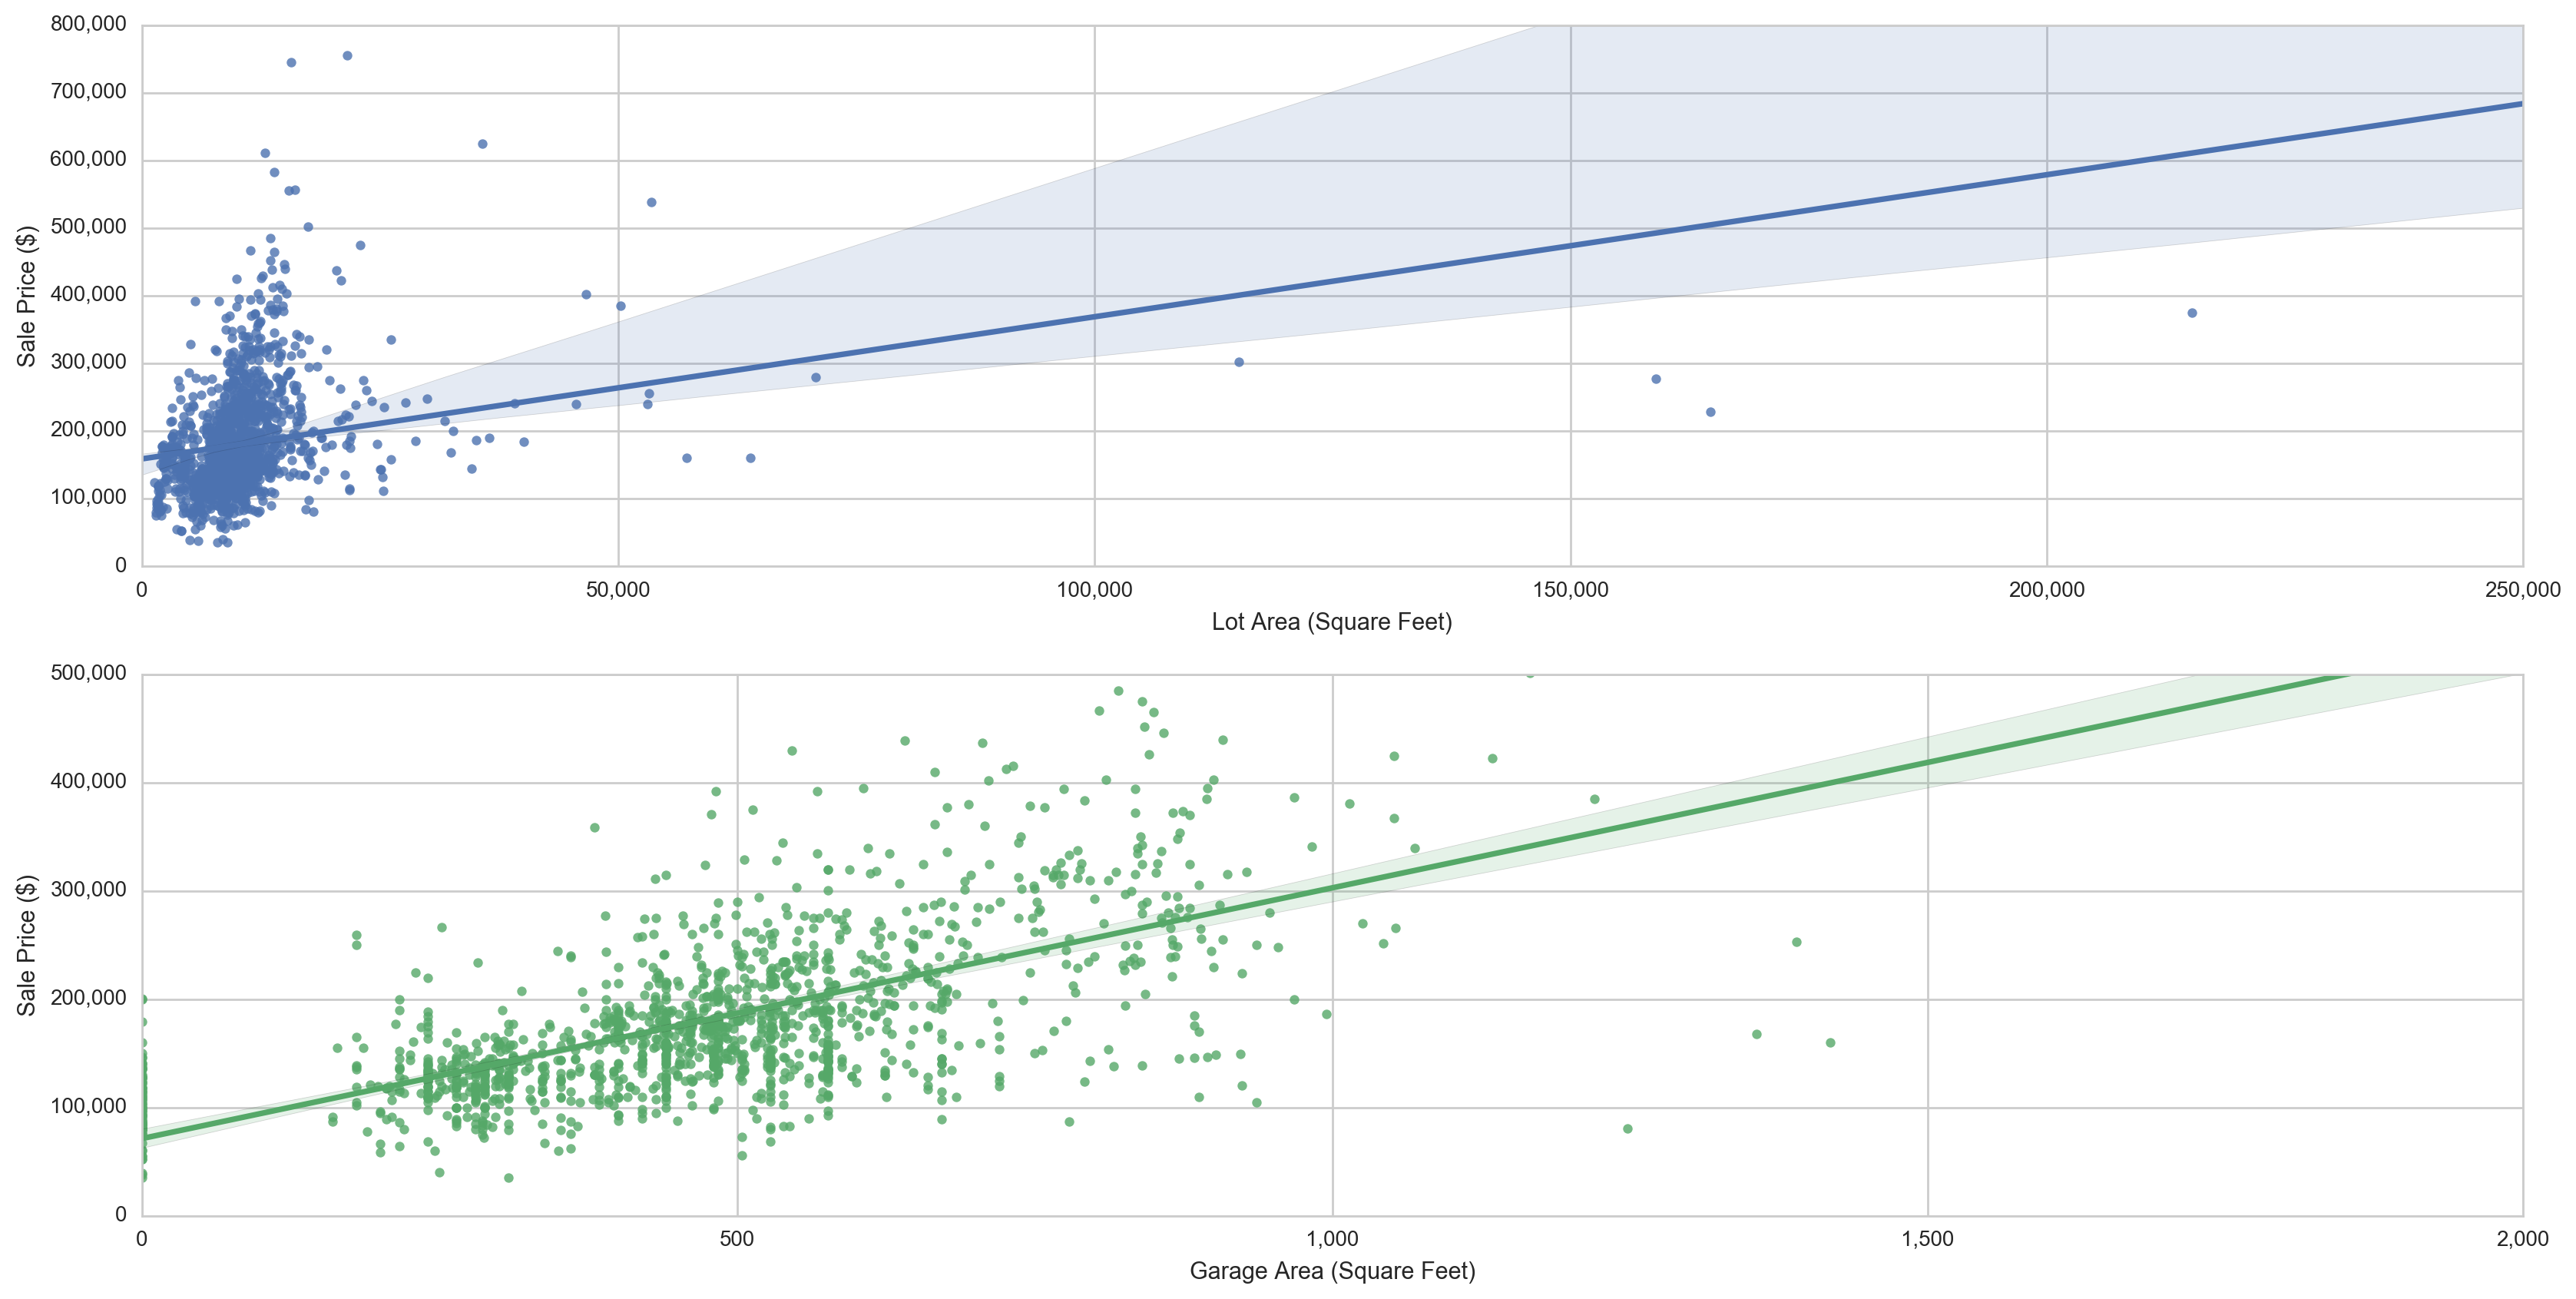

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.regplot(x=house['lotarea'], y=house['saleprice'],ax=ax[0])
sns.regplot(x=house['garagearea'], y=house['saleprice'],ax=ax[1])

ax[0].set_xlabel('Lot Area (Square Feet)')
ax[1].set_xlabel('Garage Area (Square Feet)')
ax[0].set_ylabel('Sale Price ($)')
ax[1].set_ylabel('Sale Price ($)')

ax[0].set_xlim([0,250000])
ax[1].set_ylim([0,500000])
ax[1].set_xlim([0,2000])
ax[0].set_ylim([0,800000])

ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0].get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.plt.show()

## 4. Data transformation and quality assessment

---

### 4.1 Restrict the data 

Only keep houses that are residential (remove the commercial code buildings).

In [17]:
house_res=house[~house['mszoning'].isin(['A','C (all)','C','I'])]

In [18]:
house_res.shape

(1450, 83)

### 4.2 Handle null values in the dataset

I checked all columns with null values to see what the issues was. Most of the categorical variables with null values describe a category, so I renamed as "None", which appears to be more appropriate based on the category description.

In [21]:
nulls=pd.isnull(house_res)

In [22]:
np.sum(nulls).sort_values(ascending=False).head(20)

poolqc          1443
miscfeature     1398
alley           1361
fence           1172
fireplacequ      681
lotfrontage      259
garagequal        79
garagecond        79
garagetype        79
garageyrblt       79
garagefinish      79
bsmtfintype2      38
bsmtexposure      38
bsmtqual          37
bsmtcond          37
bsmtfintype1      37
masvnrarea         8
masvnrtype         8
electrical         1
roofmatl           0
dtype: int64

In [23]:
nulls.shape

(1450, 83)

In [24]:
# Remove alley, poolqc, fence, and miscfeature, because the majority of their
# observations are nulls.
house_res.drop(['alley','poolqc','fence','miscfeature'], axis=1, inplace=True)

/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [25]:
# Drop the nulls from masvnrarea, masvnrtype, and electrical, because there are so few
house_res = house_res[~house_res.masvnrtype.isnull() & ~house_res.masvnrarea.isnull() & ~house_res.electrical.isnull()]

In [26]:
# Designate nulls as none for categorical variables
house_res.loc[pd.isnull(house_res['bsmtexposure']),'bsmtexposure']="None"
house_res.loc[pd.isnull(house_res['bsmtfintype2']),'bsmtfintype2']="None"
house_res.loc[pd.isnull(house_res['bsmtqual']),'bsmtqual']="None"
house_res.loc[pd.isnull(house_res['bsmtcond']),'bsmtcond']="None"
house_res.loc[pd.isnull(house_res['bsmtfintype1']),'bsmtfintype1']="None"
house_res.loc[pd.isnull(house_res['fireplacequ']),'fireplacequ']="None"
house_res.loc[pd.isnull(house_res['garagequal']),'garagequal']="None"
house_res.loc[pd.isnull(house_res['garagefinish']),'garagefinish']="None"
house_res.loc[pd.isnull(house_res['garagetype']),'garagetype']="None"
house_res.loc[pd.isnull(house_res['garagecond']),'garagecond']="None"

In [27]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(24,24))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

In [28]:
house_res_heat_map=house_res.loc[:, (house_res.dtypes == np.float64) | (house_res.dtypes == np.int64)]

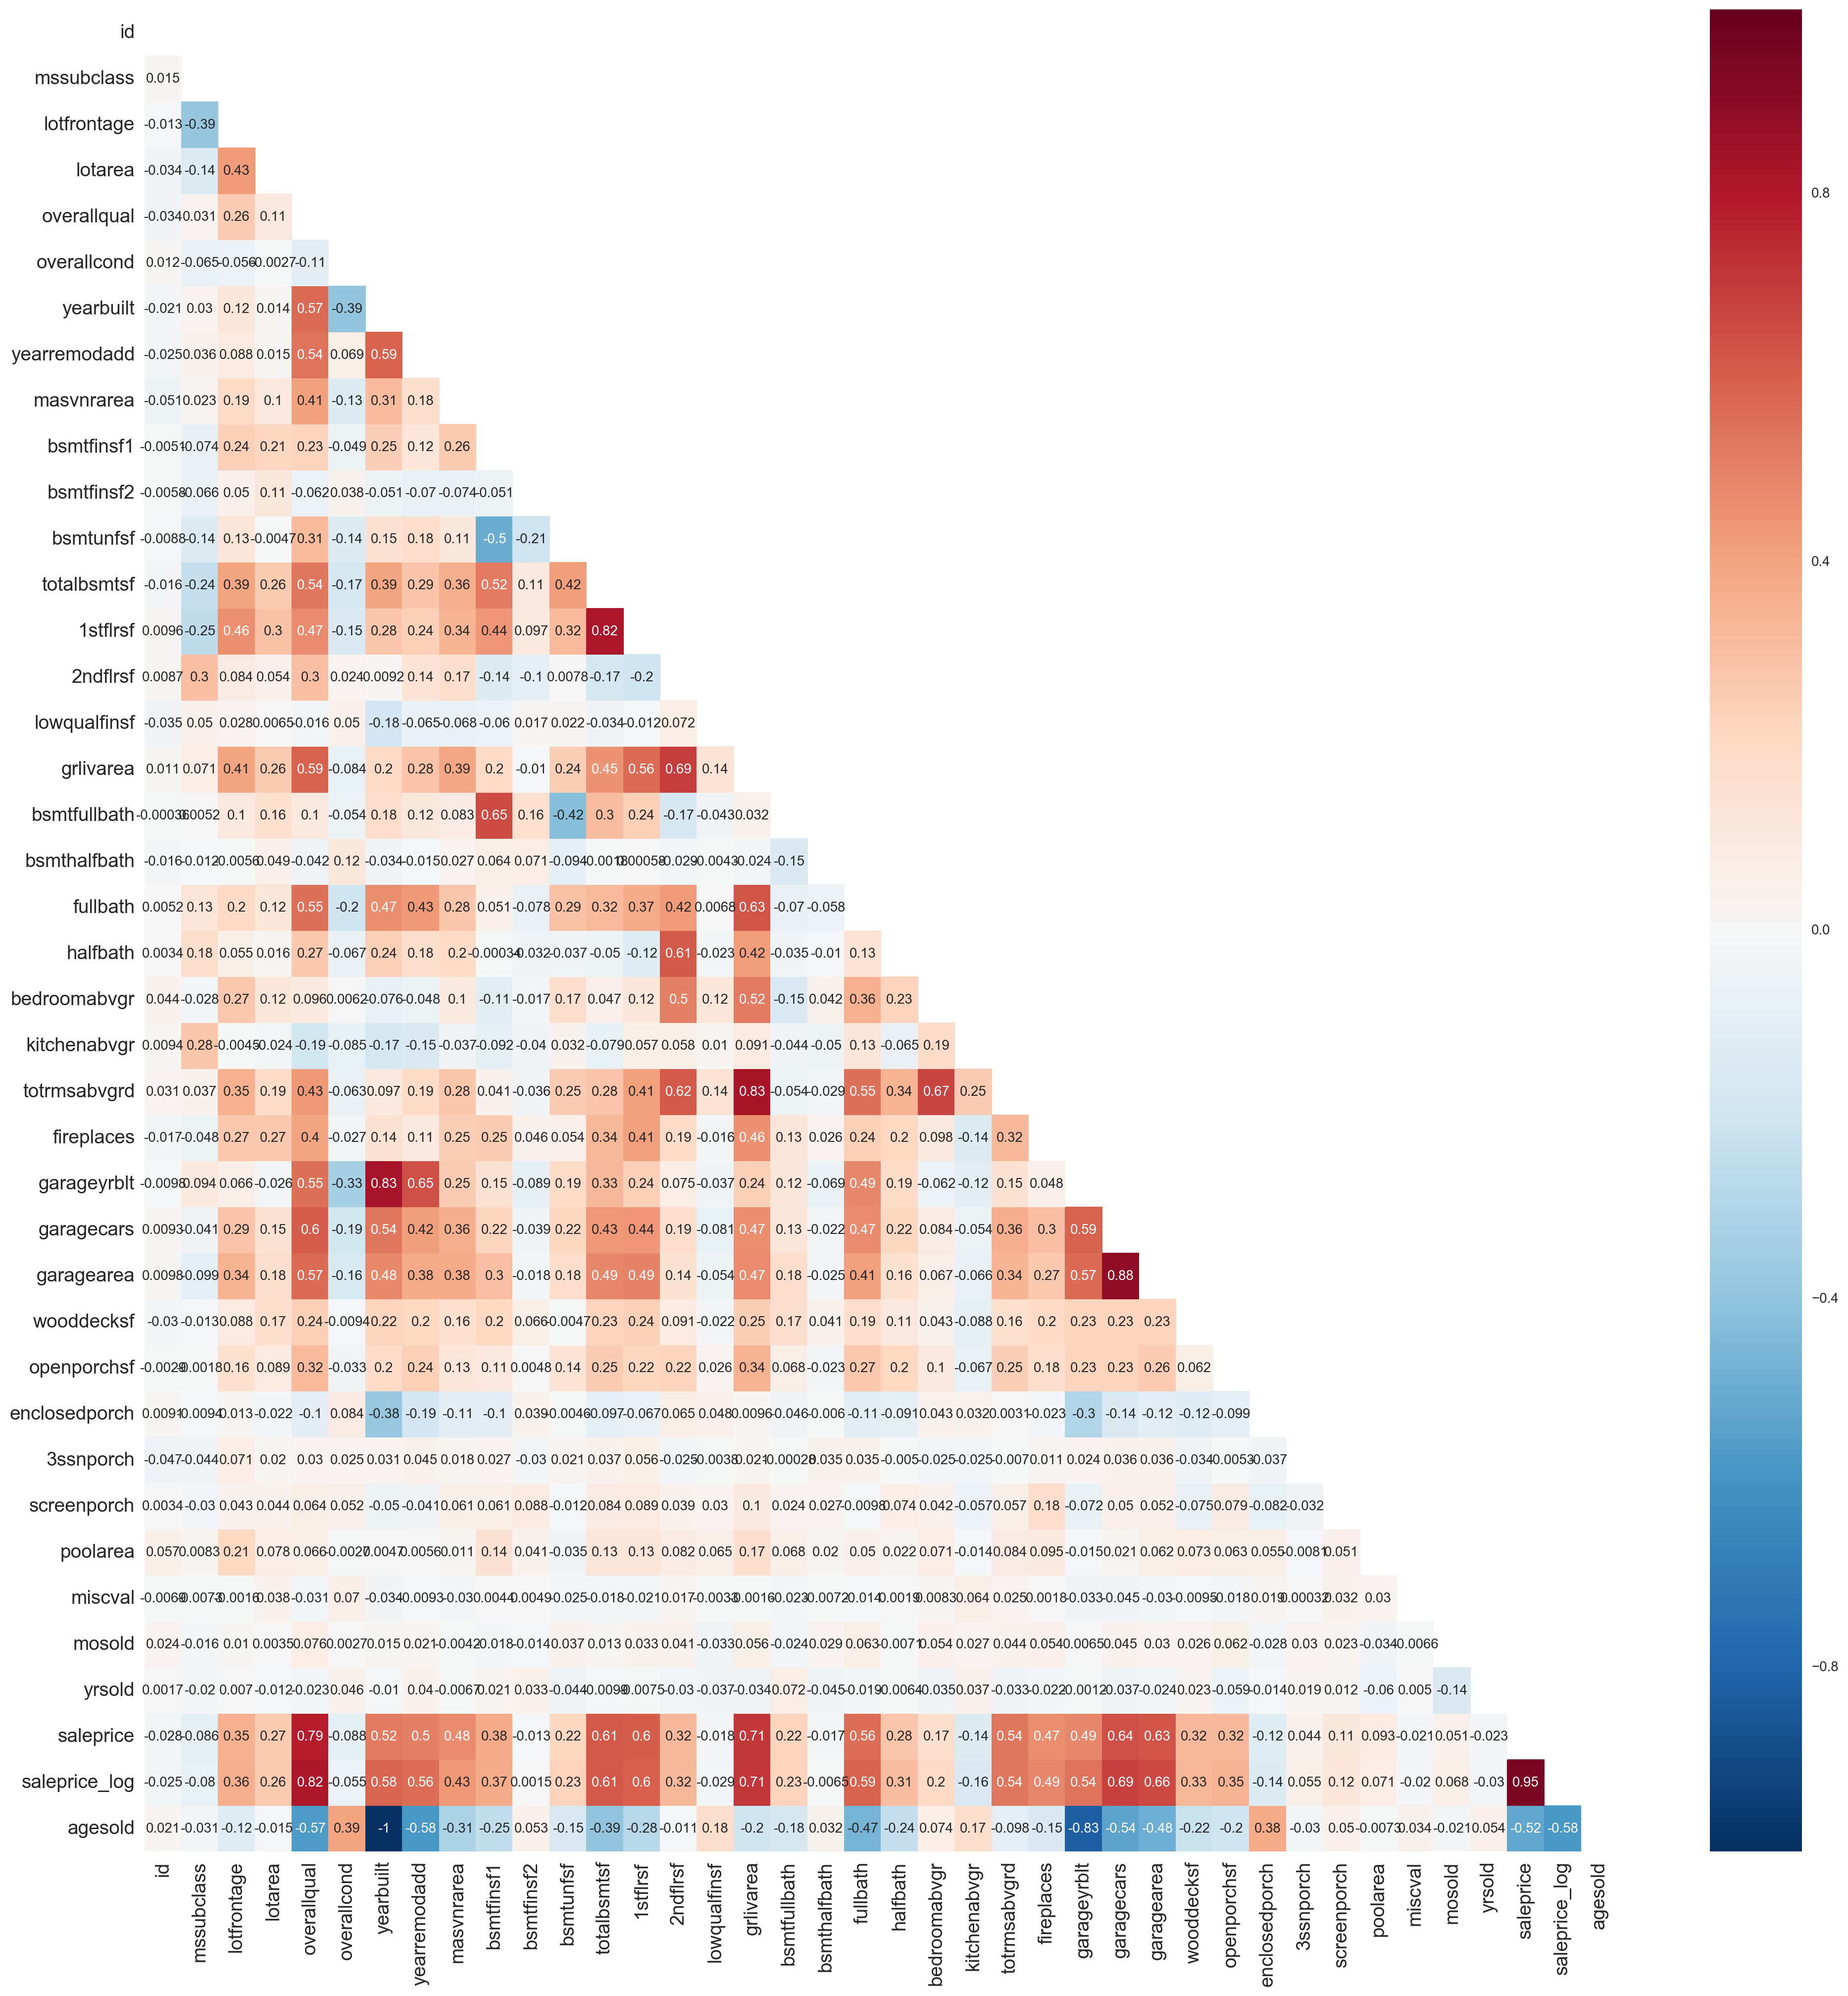

In [29]:
correlation_heat_map(house_res_heat_map.astype('float'))

In [30]:
# Use yearbuilt to fill missing garageyrblt values due to their high correlation
from sklearn.linear_model import LinearRegression

garageyrblt_correct = house_res[~house_res.garageyrblt.isnull()]
y = garageyrblt_correct[['garageyrblt']]
X = garageyrblt_correct[['yearbuilt']]
print X.shape
print y.shape
reg = LinearRegression().fit(X, y)

pred_X = house_res[house_res['garageyrblt'].isnull()][['yearbuilt']]
pred = reg.predict(pred_X)
pred=np.reshape(pred,(1,79))


# add random noise to the predicted variables
resid_sd = np.std(y - reg.predict(X))
pred = np.add(np.random.normal(0, resid_sd, size=len(pred)),pred)
pred
house_res.loc[house_res['garageyrblt'].isnull(), "garageyrblt"] = np.reshape(pred,(79,1))

(1362, 1)
(1362, 1)


In [31]:
# Use average lot frontage to fill missing values.
house_res.loc[house['lotfrontage'].isnull(), 'lotfrontage'] = np.nanmean(house_res['lotfrontage'])

Other than the yearbuilt being highly correlated with garageyrbuilt as discussed above, I found the following variables are highly positively correlated:
1. Rate of overall material and finish of the house (categorical data type) with the sale price (quantitative data type)
2. Above grade living area (quantitative data type) with the sale price (quantitative data type) and total rooms above ground
3. Above grade living area (quantitative data type) with the total rooms above grade (categorical data type)
4. Total square feet of basement area (quantitative data type) with the first floor square feet (quantitative data type)
5. Garage area (quantitative data type) with garagecars (qualitative data type)

### 4.3 Remove variables that are not viable to use as predictors of price.

I removed variables that have little to no variance with a threshold of 1 x e-1

In [32]:
house_res.var().sort_values()

saleprice_log    2.895634e-02
kitchenabvgr     4.790076e-02
bsmthalfbath     5.709673e-02
halfbath         2.531575e-01
bsmtfullbath     2.697076e-01
fullbath         3.013340e-01
fireplaces       4.144306e-01
garagecars       5.573502e-01
bedroomabvgr     6.624942e-01
overallcond      1.227426e+00
yrsold           1.762524e+00
overallqual      1.880482e+00
totrmsabvgrd     2.645559e+00
mosold           7.262472e+00
yearremodadd     4.226594e+02
lotfrontage      4.857340e+02
garageyrblt      6.237844e+02
3ssnporch        8.706912e+02
yearbuilt        9.006407e+02
agesold          9.032041e+02
poolarea         1.635413e+03
mssubclass       1.790558e+03
lowqualfinsf     2.216278e+03
screenporch      3.142164e+03
enclosedporch    3.699802e+03
openporchsf      4.227002e+03
wooddecksf       1.579044e+04
bsmtfinsf2       2.633831e+04
masvnrarea       3.295266e+04
garagearea       4.539144e+04
1stflrsf         1.482685e+05
id               1.778183e+05
2ndflrsf         1.909886e+05
totalbsmts

In [33]:
house_res=house_res.drop(['kitchenabvgr','bsmthalfbath','halfbath','bsmtfullbath','fullbath','fireplaces','garagecars',
                'bedroomabvgr'],1)

In [34]:
for col in house_res.columns:
    if (len(house_res[col].unique()))<20:
        print (house_res[col].value_counts())
        print ('----------------------')

20     530
60     296
50     140
120     86
30      67
160     63
70      59
80      57
90      52
190     29
85      20
75      16
45      12
180     10
40       4
Name: mssubclass, dtype: int64
----------------------
RL    1145
RM     218
FV      62
RH      16
Name: mszoning, dtype: int64
----------------------
Pave    1437
Grvl       4
Name: street, dtype: int64
----------------------
Reg    909
IR1    481
IR2     41
IR3     10
Name: lotshape, dtype: int64
----------------------
Lvl    1296
Bnk      62
HLS      49
Low      34
Name: landcontour, dtype: int64
----------------------
AllPub    1440
NoSeWa       1
Name: utilities, dtype: int64
----------------------
Inside     1037
Corner      260
CulDSac      93
FR2          47
FR3           4
Name: lotconfig, dtype: int64
----------------------
Gtl    1366
Mod      62
Sev      13
Name: landslope, dtype: int64
----------------------
Norm      1243
Feedr       79
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8


In [35]:
# Drop categorical variables street, utilities, condition2, roofmatl, heating, paveddrive, and poolarea, because
# they have very little variation between categories
house_res=house_res.drop(['utilities','condition2','roofmatl','heating','paveddrive','poolarea'],1)

## 5. Make boxplots of categorical variables against the sale price

In [39]:
house_res_cat=house_res.loc[:, (house_res.dtypes ==np.object)]
house_res_cat.loc[:,'saleprice']=house_res.loc[:,'saleprice']

/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [40]:
house_res_cat.columns

Index([u'mszoning', u'street', u'lotshape', u'landcontour', u'lotconfig',
       u'landslope', u'neighborhood', u'condition1', u'bldgtype',
       u'housestyle', u'roofstyle', u'exterior1st', u'exterior2nd',
       u'masvnrtype', u'exterqual', u'extercond', u'foundation', u'bsmtqual',
       u'bsmtcond', u'bsmtexposure', u'bsmtfintype1', u'bsmtfintype2',
       u'heatingqc', u'centralair', u'electrical', u'kitchenqual',
       u'functional', u'fireplacequ', u'garagetype', u'garagefinish',
       u'garagequal', u'garagecond', u'saletype', u'salecondition',
       u'saleprice'],
      dtype='object')

I think it is interesting that homes that were not completed when last assessed had a higher median sale price than all other sale categories. I would have thought that sale price would be lower than other sale categories, because the house is not complete. 

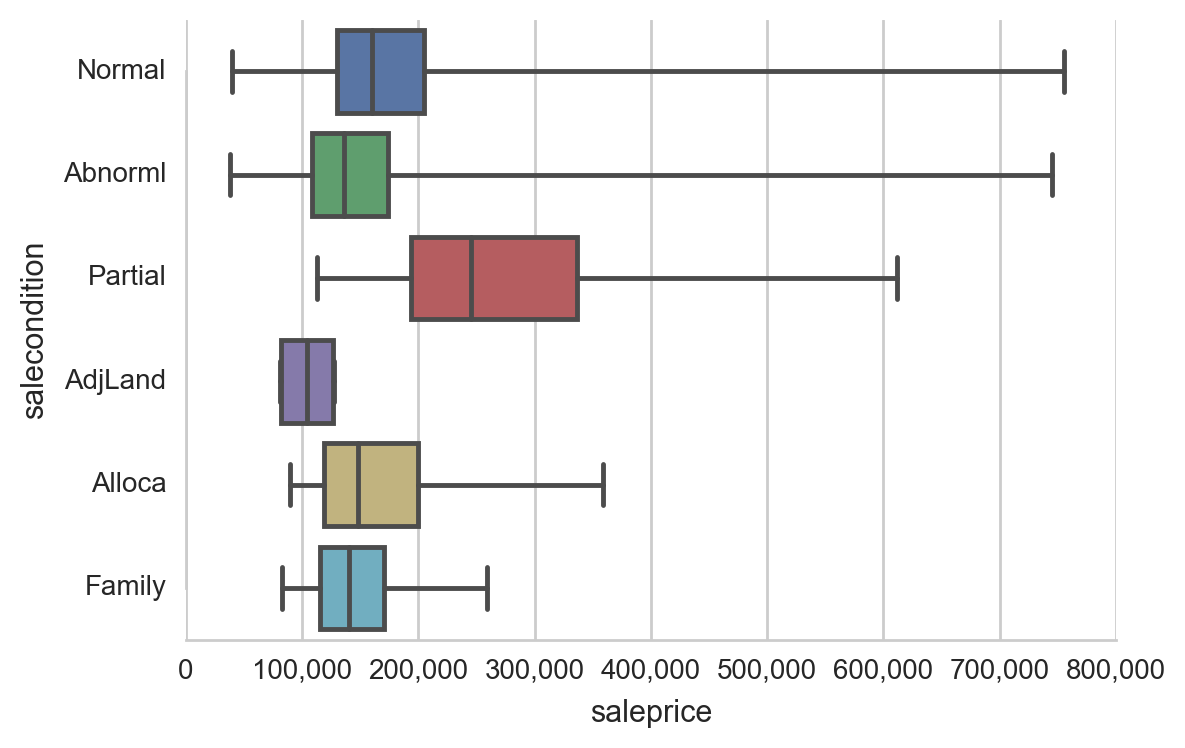

In [41]:
plot=sns.boxplot(y="salecondition", x="saleprice", data=house_res_cat,
                 whis=np.inf)

plot.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.despine(trim=True)

New homes and homes offered with a 15% down payment with regular terms commanded the highest median sale prices compared to other sales types. 

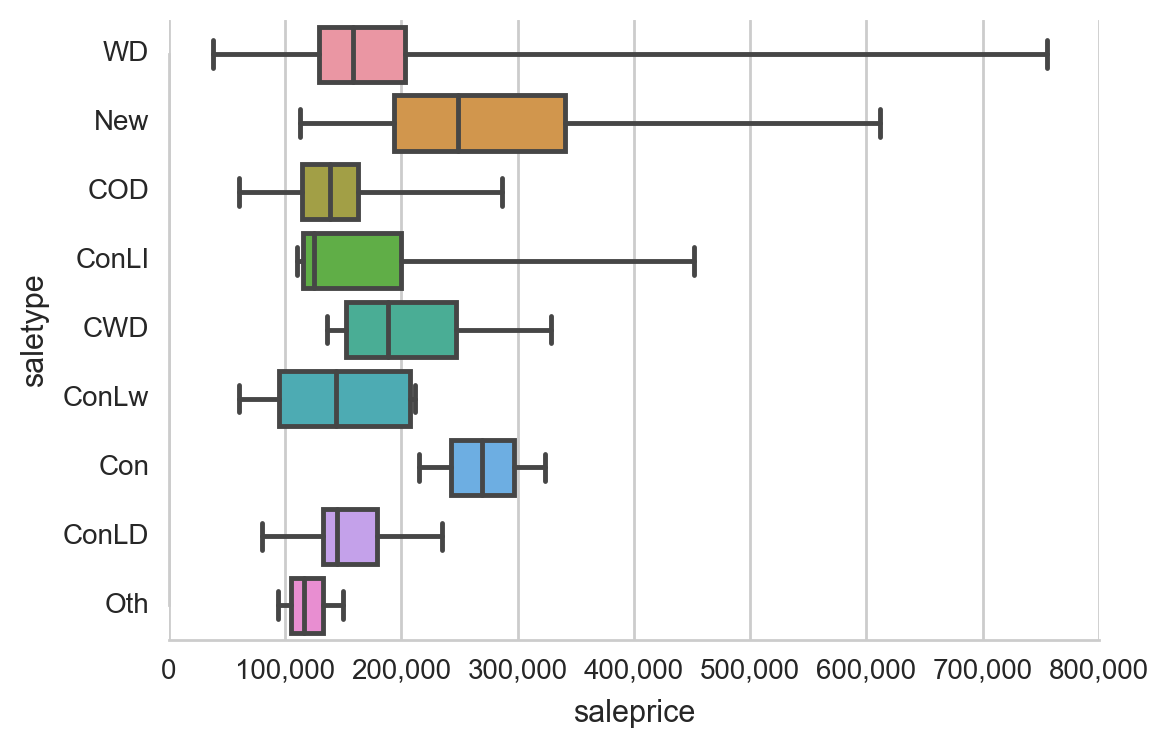

In [42]:
plot=sns.boxplot(y="saletype", x="saleprice", data=house_res_cat,whis=np.inf)
plot.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.despine(trim=True)

Homes with electrical mixed, fuse in average condition, and fuse box in fair condition had sales prices within a relatively narrow range compared to electrical with Standard Circuit Breakers & Romex. 

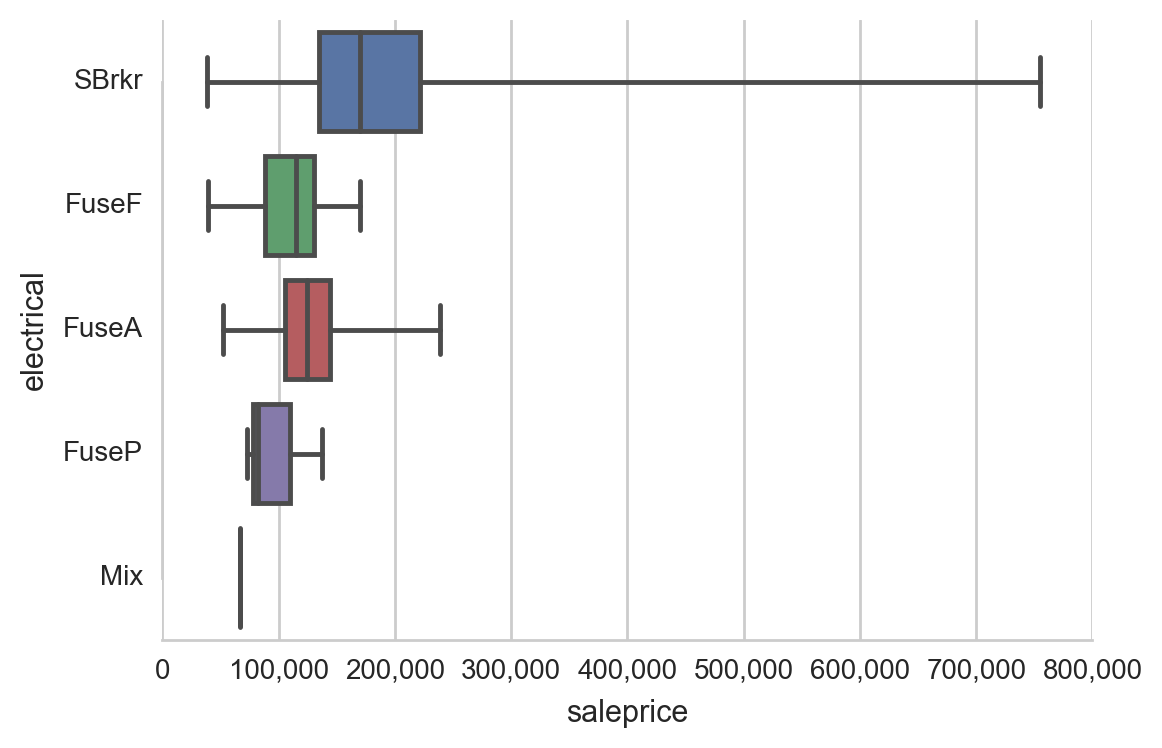

In [43]:
plot = sns.boxplot(y="electrical", x="saleprice", data=house_res_cat,
                 whis=np.inf)
plot.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.despine(trim=True)

Interesting to see that medium and high density residential tend to have lower sales price compared to less dense development. 

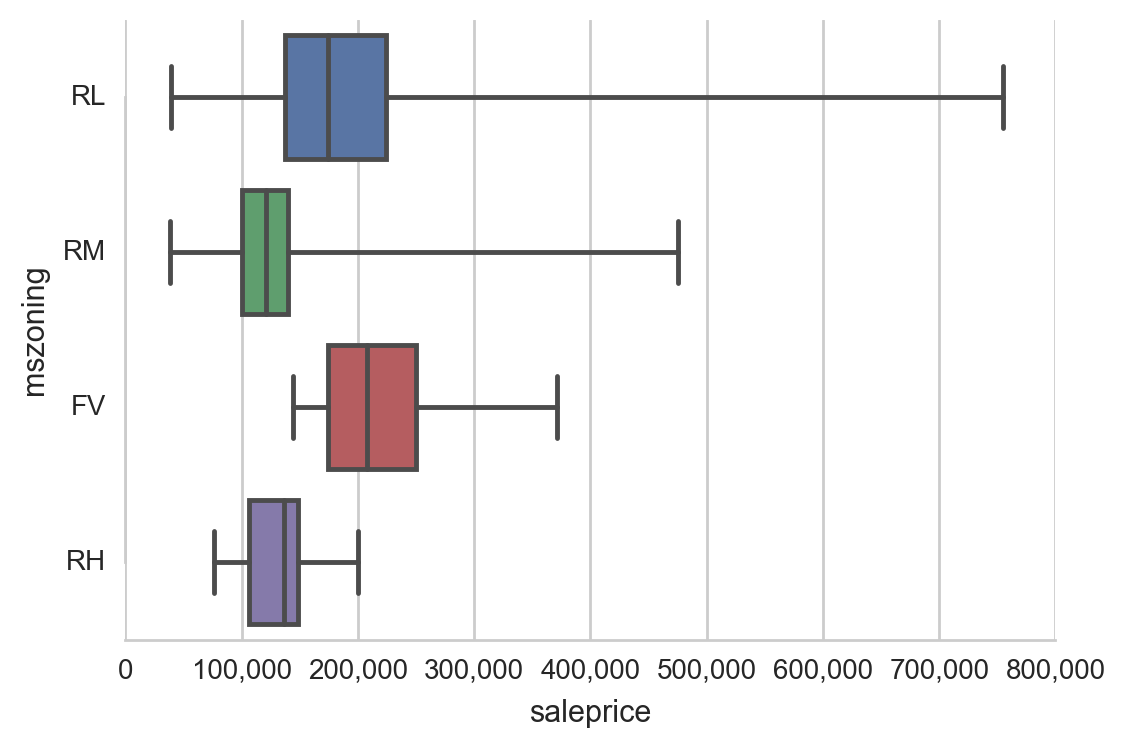

In [44]:
plot= sns.boxplot(y="mszoning", x="saleprice", data=house_res_cat,
                 whis=np.inf)
plot.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.despine(trim=True)

Homes with a property slope moderate to severe have relatively higher median sales prices than homes with a gentle slope. 

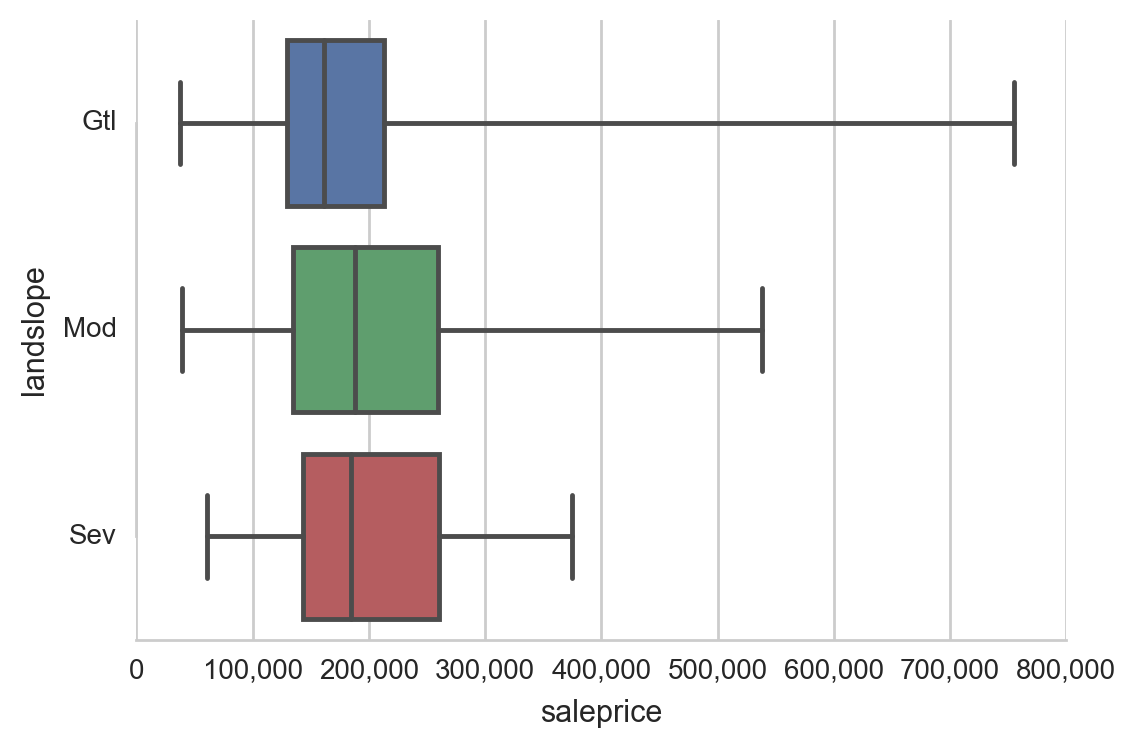

In [45]:
plot= sns.boxplot(y="landslope", x="saleprice", data=house_res_cat,
                 whis=np.inf)
plot.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.despine(trim=True)

Fair, poor, and houses without basements tend to command a lower salesprice than basements in typical or good condition. 

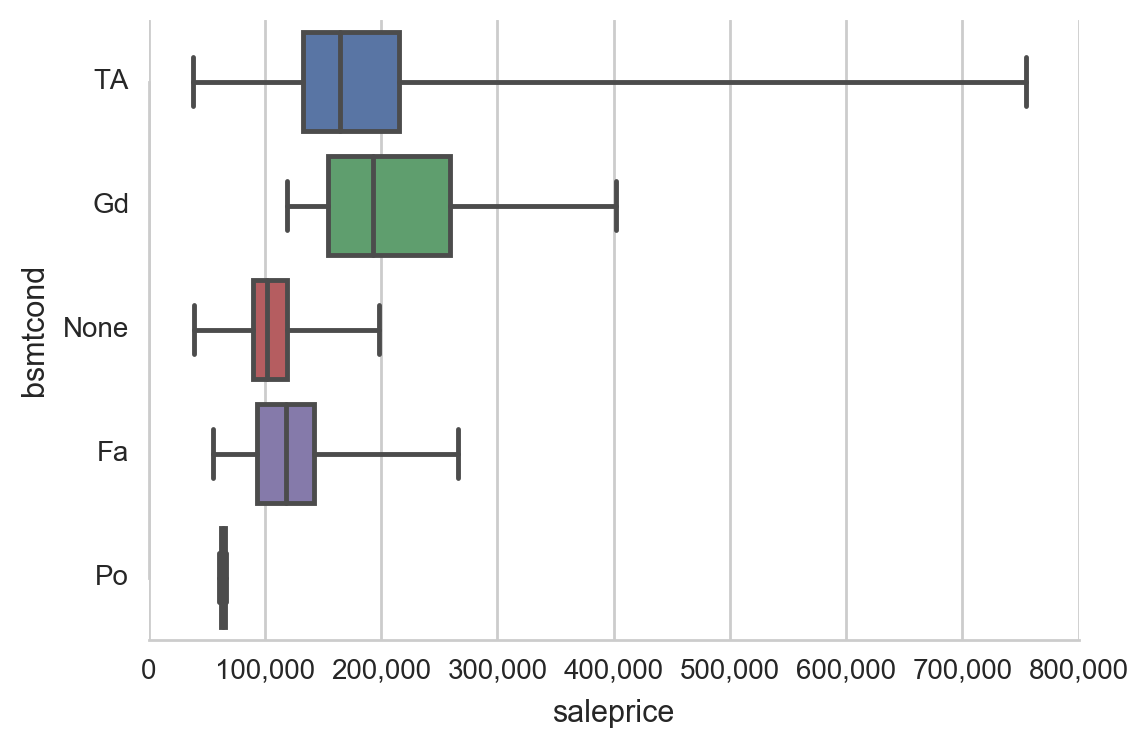

In [46]:
plot = sns.boxplot(y="bsmtcond", x="saleprice", data=house_res_cat,
                 whis=np.inf)
plot.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.despine(trim=True)

Homes with good and excellent quality of material on the exterior tend to have considerably greater sales prices compared to all other categories. 

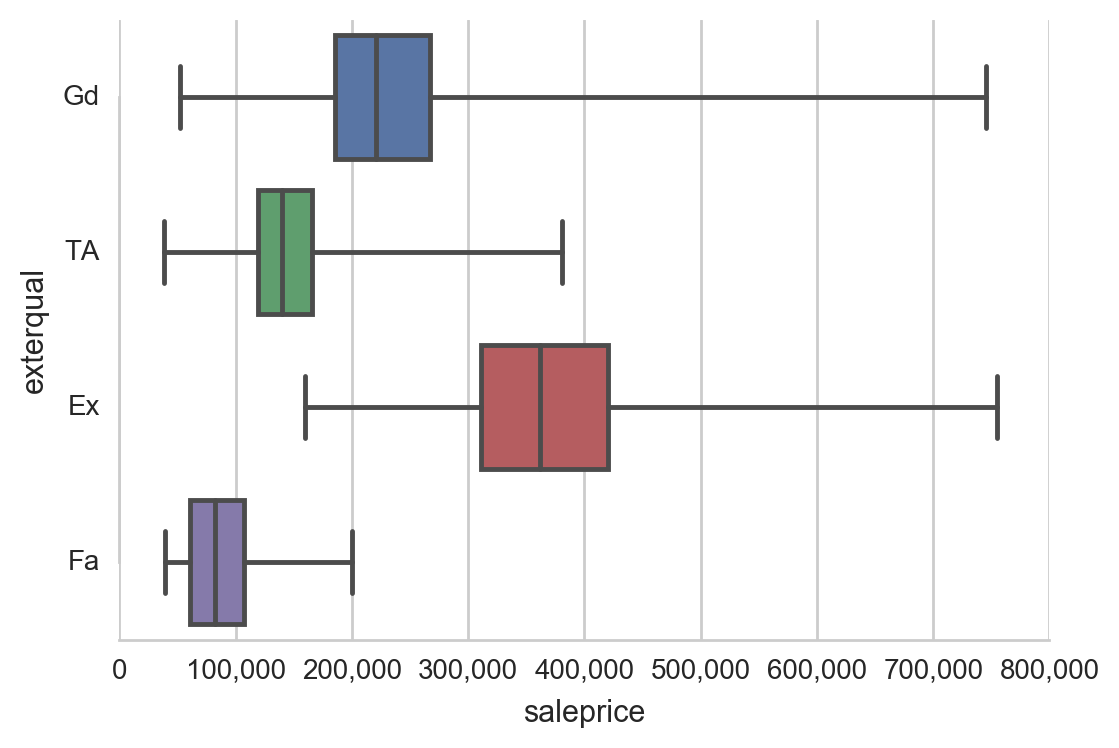

In [47]:
plot = sns.boxplot(y="exterqual", x="saleprice", data=house_res_cat,
                 whis=np.inf)
plot.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.despine(trim=True)

A house with a garage with a typical quality can command a sales price just as high as a house with a garage in poor or excellent condition. 

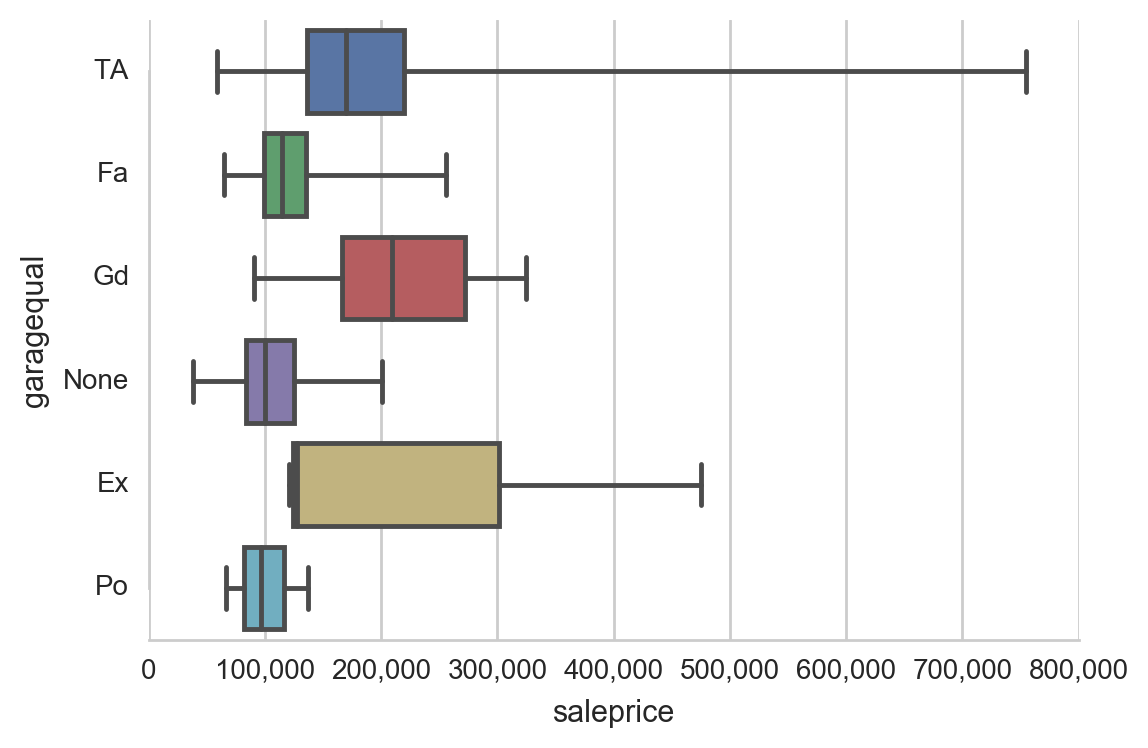

In [48]:
plot = sns.boxplot(y="garagequal", x="saleprice", data=house_res,
                 whis=np.inf)
plot.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
sns.despine(trim=True)

## 6. Univariate regression predicting price with statsmodels

---

### 6.1 Build a linear regression with statsmodels predicting sales price from total living area sq ft.

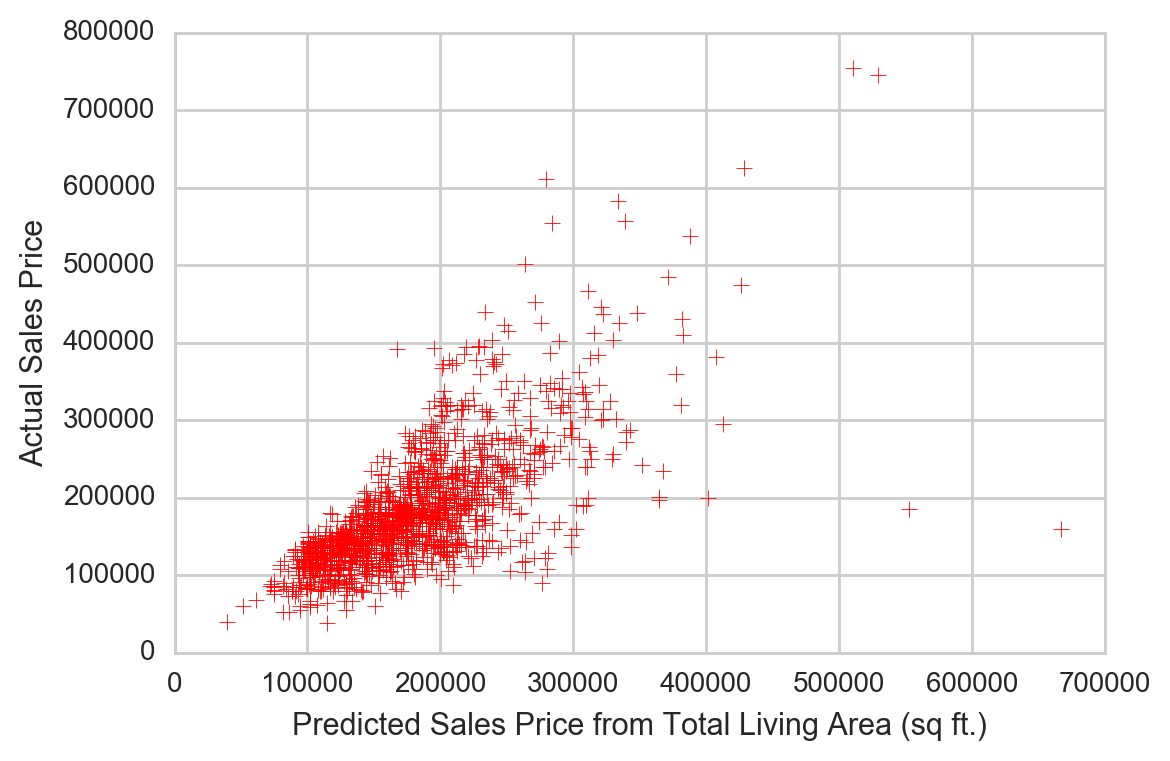

MSE: 3135379491.22
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 1.653e+04
Date:                Mon, 22 May 2017   Prob (F-statistic):               0.00
Time:                        13:37:37   Log-Likelihood:                -17799.
No. Observations:                1441   AIC:                         3.560e+04
Df Residuals:                    1440   BIC:                         3.561e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grlivarea    118.2294      0.919 

In [49]:
import statsmodels.api as sm

lm = linear_model.LinearRegression()

X = house_res[["grlivarea"]]
y = house_res[["saleprice"]]


model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Sales Price from Total Living Area (sq ft.)")
plt.ylabel("Actual Sales Price")
plt.show()

print "MSE:", mean_squared_error(y, predictions)
print model.summary()

Basic Interpretation:
1. The intercept represents the point the linear regression model intersects the y-axis. 
2. The coefficient on grlivarea respresents the change in the log of the sales price per unit change in grlivarea with the addition of the intercept term.
3. The R-squared value represents the percent of the variance explained in the log of teh sales price above baseline by the grlivarea variable.
4. The p-value for the coefficient represents the probability that the the null hypothesis is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis and accept the coefficient values calculated.

## 7. Multivariate regression predicting price with sklearn

---

### 7.1 Build an sklearn linear regression predicting sale price using all continuous measures as predictors 

In [50]:
house_res_cont=house_res.loc[:, (house_res.dtypes == np.float64) | (house_res.dtypes == np.int64)]
house_res_cont=house_res_cont.drop(['id','saleprice'],axis=1)

In [51]:
len(house_res_cont.columns)

29

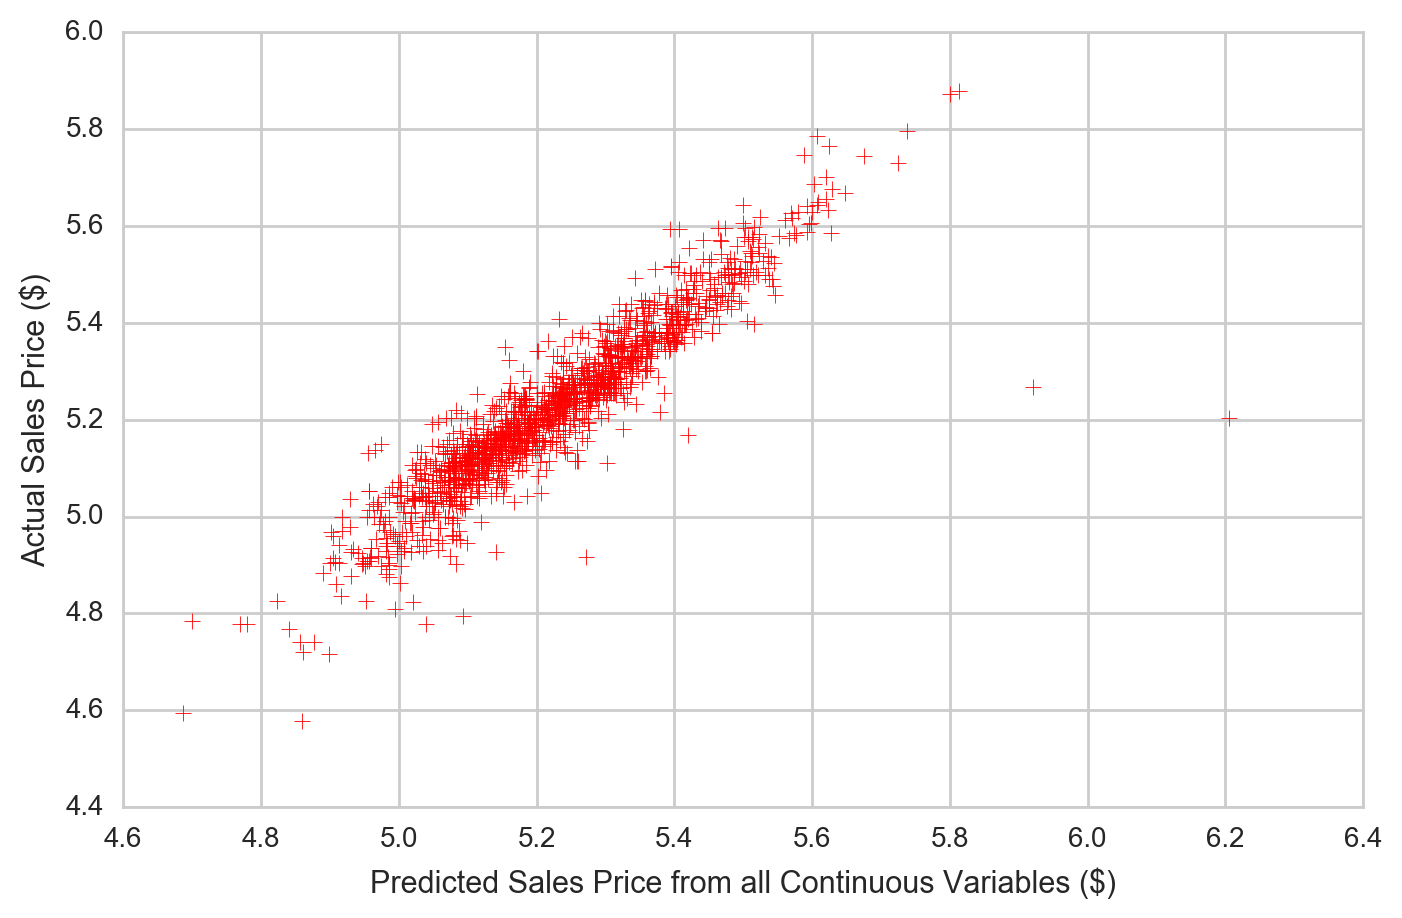

MSE: 
0.004129 

Coefficients ('RM'): 
[ -3.05739719e-04  -1.91352067e-04   1.13424324e-06   4.12648058e-02
   1.87746066e-02   3.09717039e-04   5.59881311e-04   8.36586838e-07
   2.08371692e-05   1.20211327e-05  -8.96967386e-06   2.38886280e-05
   3.81601785e-05   3.14038290e-05  -1.25439717e-05   5.70200359e-05
   6.87129251e-03  -2.21023809e-04   9.92296737e-05   6.61738347e-05
   2.30191089e-05   8.93785639e-05   1.12984938e-04   1.90743315e-04
  -3.80399386e-06   5.94430569e-04  -9.33305541e-04  -1.24302258e-03] 

R^2 / Variance Explained Score (1 = perfect score): 
0.857307 



In [52]:
lm = linear_model.LinearRegression()
X=house_res_cont.drop('saleprice_log',axis=1)
y=house_res_cont['saleprice_log']
model = lm.fit(X, y)
predictions = lm.predict(X)
score        =  model.score(X, y)



# Plot the model
plt.figure(figsize=(8, 5))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Sales Price from all Continuous Variables ($)")
plt.ylabel("Actual Sales Price ($)")
plt.show()

print "MSE: \n%f \n" % mean_squared_error(y, predictions)
print "Coefficients ('RM'): \n%s \n" % model.coef_

print "R^2 / Variance Explained Score (1 = perfect score): \n%f \n" % score

### 7.2 Plot the residuals against the true values.

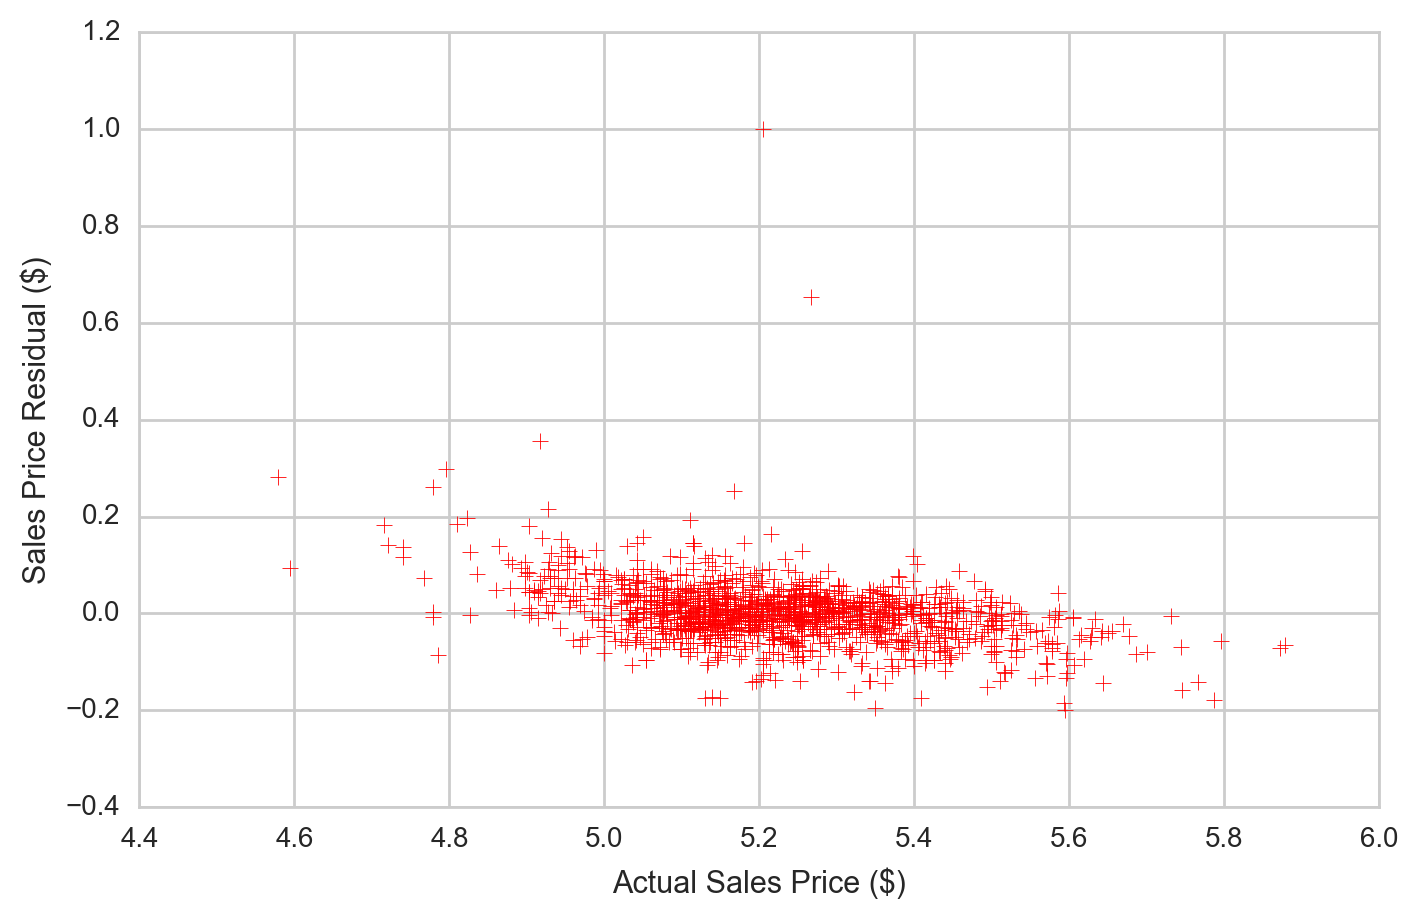

In [53]:
residuals=predictions-y

plt.figure(figsize=(8, 5))
plt.scatter(y=residuals, x=y, s=30, c='r', marker='+', zorder=10)
plt.ylabel("Sales Price Residual ($)")
plt.xlabel("Actual Sales Price ($)")
plt.show()

### 7.4 Plot a histogram of the residuals.

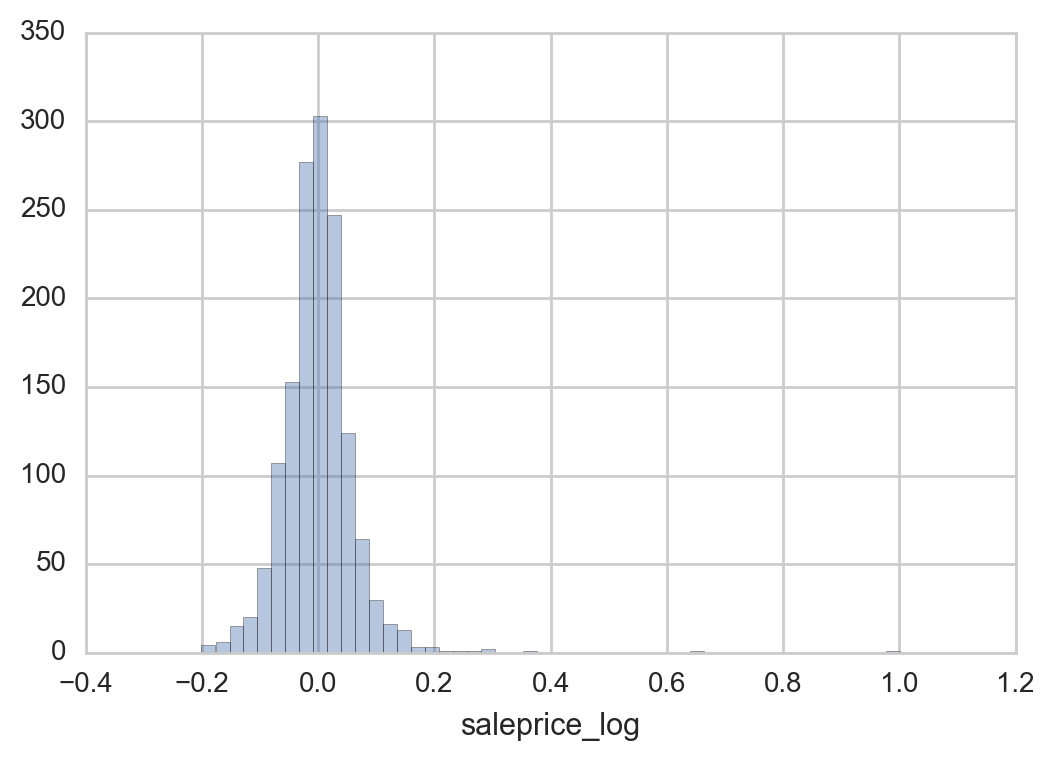

In [54]:
sns.distplot(residuals, bins=50, kde=False)

### 7.5 Make a plot to show the strength of the different coefficients.

            label         value
27        agesold -1.243023e-03
26         yrsold -9.333055e-04
0      mssubclass -3.057397e-04
17    garageyrblt -2.210238e-04
1     lotfrontage -1.913521e-04
14   lowqualfinsf -1.254397e-05
10      bsmtunfsf -8.969674e-06
24        miscval -3.803994e-06
7      masvnrarea  8.365868e-07
2         lotarea  1.134243e-06
9      bsmtfinsf2  1.202113e-05
8      bsmtfinsf1  2.083717e-05
20    openporchsf  2.301911e-05
11    totalbsmtsf  2.388863e-05
13       2ndflrsf  3.140383e-05
12       1stflrsf  3.816018e-05
15      grlivarea  5.702004e-05
19     wooddecksf  6.617383e-05
21  enclosedporch  8.937856e-05
18     garagearea  9.922967e-05
22      3ssnporch  1.129849e-04
23    screenporch  1.907433e-04
5       yearbuilt  3.097170e-04
6    yearremodadd  5.598813e-04
25         mosold  5.944306e-04
16   totrmsabvgrd  6.871293e-03
4     overallcond  1.877461e-02
3     overallqual  4.126481e-02


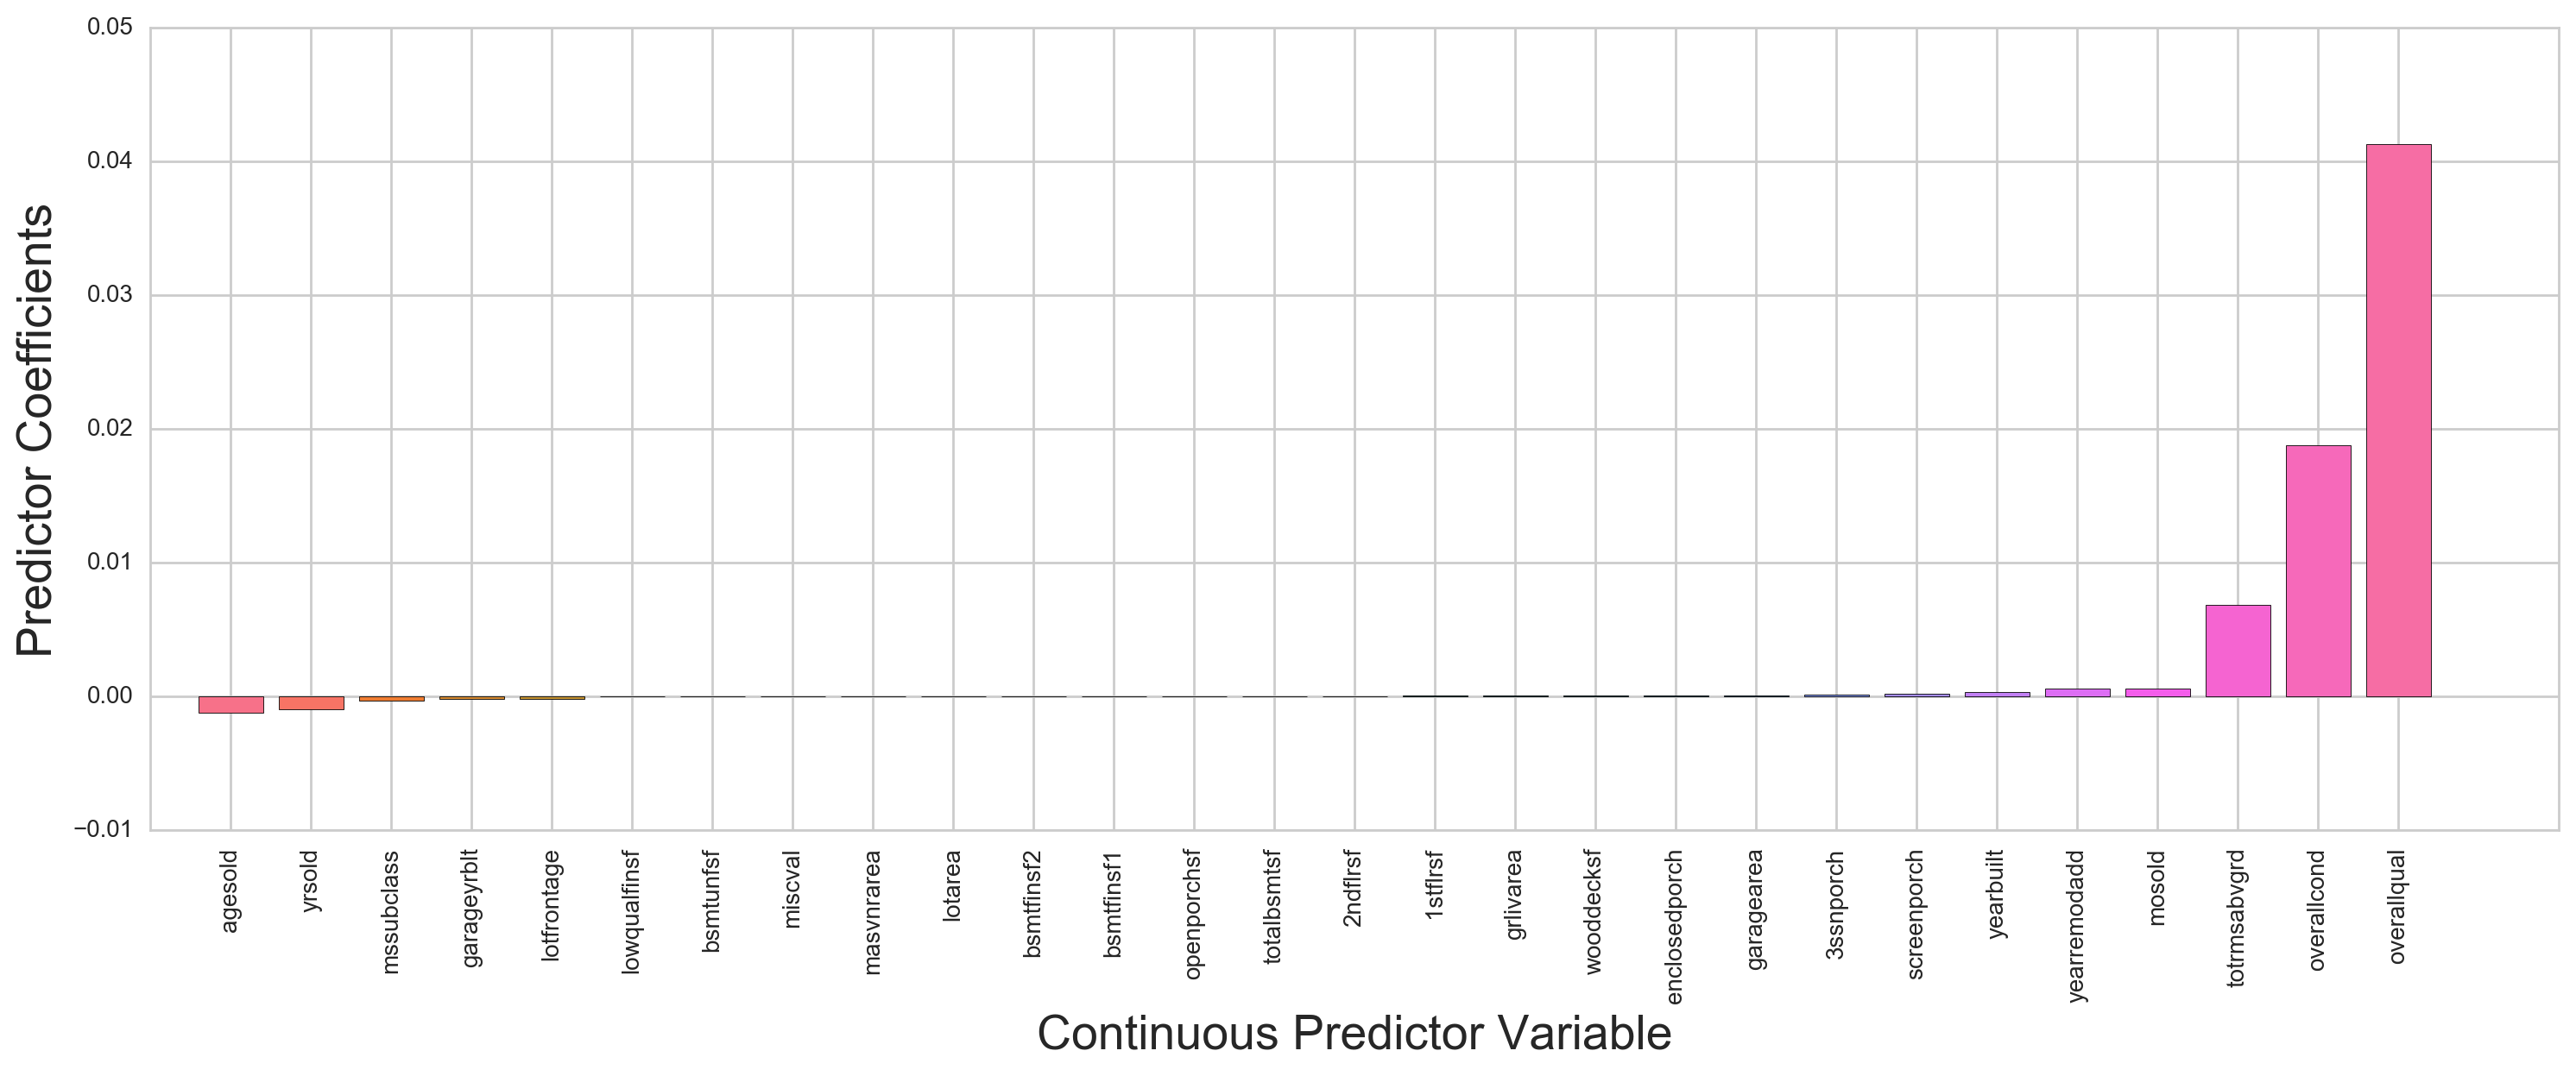

In [55]:
fig,ax = plt.subplots(1, 1, figsize=(18, 6))

coef_dic={'label':X.columns,'value':model.coef_}
bar_coeffs =pd.DataFrame(coef_dic)
bar_coeffs=bar_coeffs.sort_values('value')
print bar_coeffs


# Position the bars according to their index from the feature names variable:
colors = sns.color_palette("husl", len(X.columns))
ax.bar(np.arange(1, len(X.columns)+1), bar_coeffs['value'], align='center', color=colors)
ax.set_xticks(range(1, len(X.columns)+1))
    
# Reset the ticks from numbers to acutally be the names:
ax.set_xticklabels(bar_coeffs['label'], rotation=90)
    
# enforce limits and add titles, labels
#ax2.set_ylim([ymin, ymax])
ax.set_xlabel('Continuous Predictor Variable', fontsize=20)
ax.set_ylabel('Predictor Coefficients', fontsize=20)

## 8. Create a predictor matrix using all viable predictors available

---

###  8.1 Fit a linear regression using all of the predictors and score it.

In [56]:
from patsy import dmatrix, demo_data, ContrastMatrix, Poly

print house_res.columns
print "length", len(house_res.columns)

Index([u'id', u'mssubclass', u'mszoning', u'lotfrontage', u'lotarea',
       u'street', u'lotshape', u'landcontour', u'lotconfig', u'landslope',
       u'neighborhood', u'condition1', u'bldgtype', u'housestyle',
       u'overallqual', u'overallcond', u'yearbuilt', u'yearremodadd',
       u'roofstyle', u'exterior1st', u'exterior2nd', u'masvnrtype',
       u'masvnrarea', u'exterqual', u'extercond', u'foundation', u'bsmtqual',
       u'bsmtcond', u'bsmtexposure', u'bsmtfintype1', u'bsmtfinsf1',
       u'bsmtfintype2', u'bsmtfinsf2', u'bsmtunfsf', u'totalbsmtsf',
       u'heatingqc', u'centralair', u'electrical', u'1stflrsf', u'2ndflrsf',
       u'lowqualfinsf', u'grlivarea', u'kitchenqual', u'totrmsabvgrd',
       u'functional', u'fireplacequ', u'garagetype', u'garageyrblt',
       u'garagefinish', u'garagearea', u'garagequal', u'garagecond',
       u'wooddecksf', u'openporchsf', u'enclosedporch', u'3ssnporch',
       u'screenporch', u'miscval', u'mosold', u'yrsold', u'saletype',
       u

In [57]:
# rename colujmns names with numbers in the name, so Patsy is not confused
house_res.rename(columns={'1stflrsf':'firstflrsf', '2ndflrsf':'secondflrsf',
                      '3ssnporch':'threessnporch'}, inplace=True)

In [58]:
import patsy

formula = "saleprice_log ~ "+' + '.join([x for x in house_res.columns if not x in ['saleprice','saleprice_log','id']])+' -1'
formula

'saleprice_log ~ mssubclass + mszoning + lotfrontage + lotarea + street + lotshape + landcontour + lotconfig + landslope + neighborhood + condition1 + bldgtype + housestyle + overallqual + overallcond + yearbuilt + yearremodadd + roofstyle + exterior1st + exterior2nd + masvnrtype + masvnrarea + exterqual + extercond + foundation + bsmtqual + bsmtcond + bsmtexposure + bsmtfintype1 + bsmtfinsf1 + bsmtfintype2 + bsmtfinsf2 + bsmtunfsf + totalbsmtsf + heatingqc + centralair + electrical + firstflrsf + secondflrsf + lowqualfinsf + grlivarea + kitchenqual + totrmsabvgrd + functional + fireplacequ + garagetype + garageyrblt + garagefinish + garagearea + garagequal + garagecond + wooddecksf + openporchsf + enclosedporch + threessnporch + screenporch + miscval + mosold + yrsold + saletype + salecondition + agesold -1'

In [59]:
# # Create the X and Y pairs for both!
Y, X = patsy.dmatrices(formula, data=house_res,return_type='dataframe')

print Y.shape
print X.shape

(1441, 1)
(1441, 216)


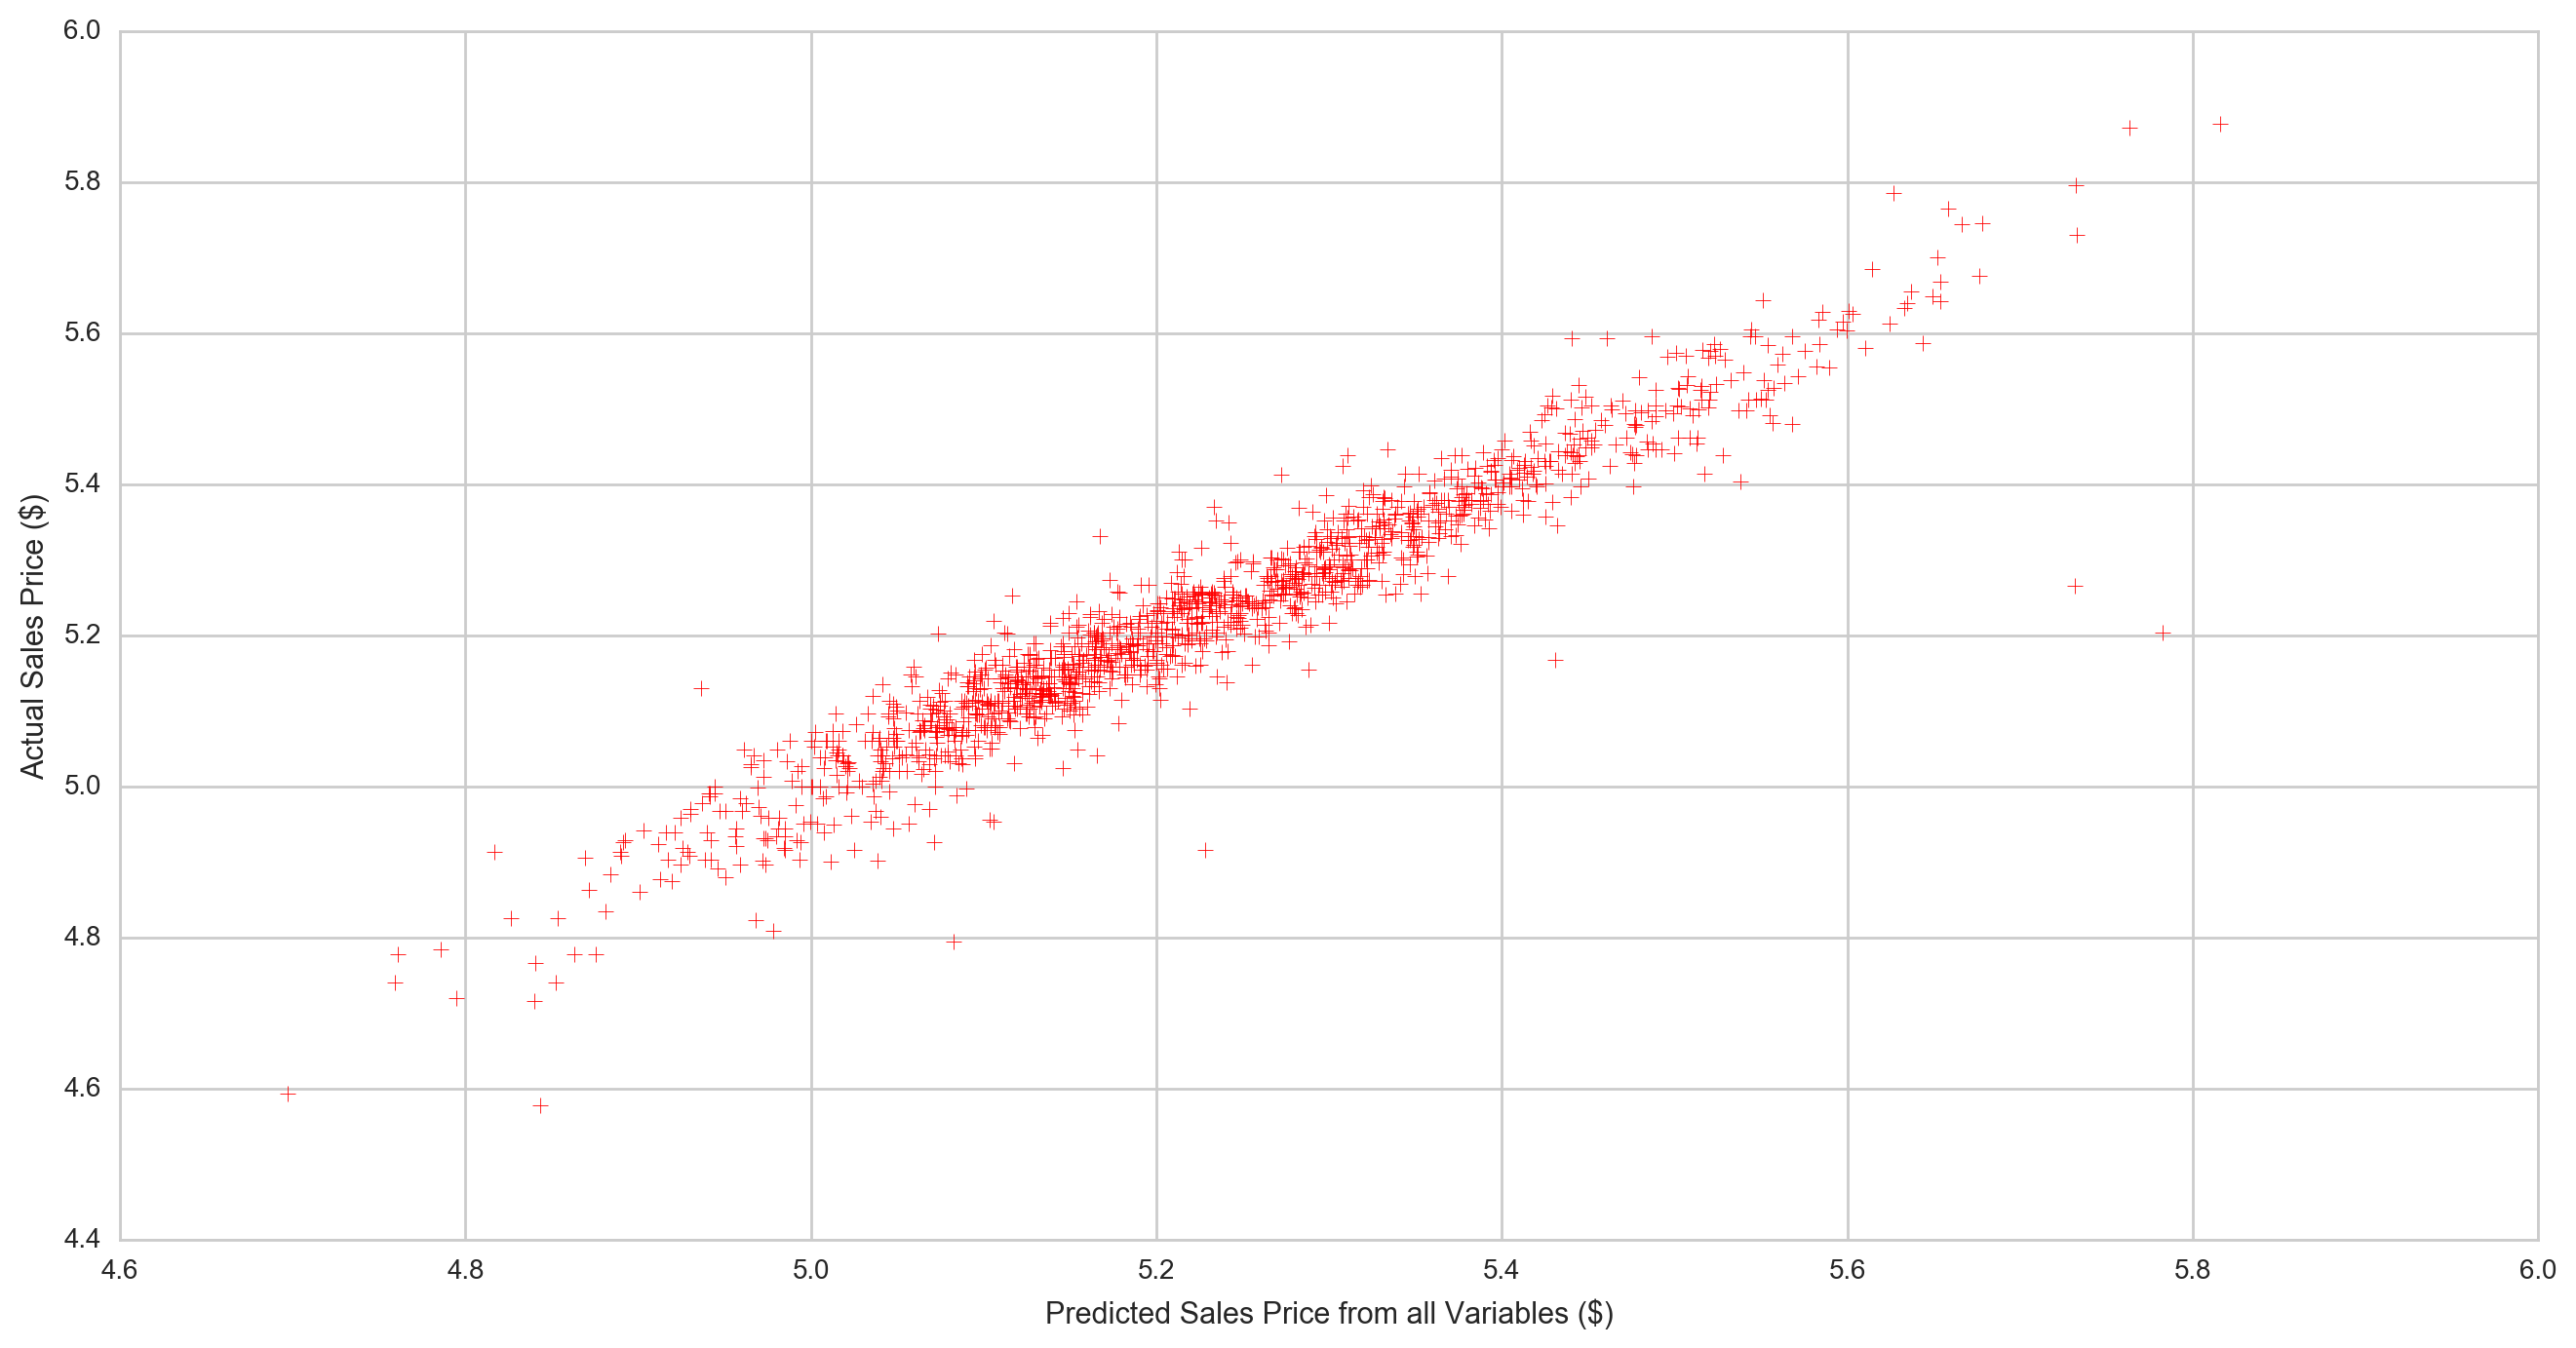

MSE: 
0.002334 

Coefficients ('RM'): 
[[  1.26044092e-02   1.28345353e-03   1.32966340e-03  -1.52175261e-02
    1.46074784e-02   9.81472424e-03  -4.13774964e-02   4.23433568e-03
    3.18916225e-02   2.21429054e-02   3.43334123e-02   1.08038849e-02
   -2.03846418e-02  -3.53882996e-02  -8.06885013e-03   1.44767135e-02
   -4.86233877e-02  -2.88031750e-02  -1.70757239e-02   9.34527264e-03
    3.10183114e-02   4.35808602e-03   6.15169351e-02  -3.79486218e-02
    1.21295762e-02  -1.53014039e-02  -6.83309350e-02  -1.20835320e-02
   -8.42436123e-03   3.63985386e-03  -4.44601442e-03   5.26535063e-02
    6.27482237e-02  -2.14275101e-02   1.15117743e-02  -7.18716779e-03
    8.47974450e-03   2.96386538e-02   8.36650814e-02   1.77973053e-02
    3.57588803e-02   3.12240748e-03   3.22904562e-02   1.78584574e-02
    1.28828903e-03  -1.21673697e-02   2.06063594e-02  -6.88873818e-04
    4.27348302e-02   2.33913743e-02  -4.34869004e-03  -3.84537199e-02
   -2.14733660e-02   3.89892045e-03   1.01714062e-0

In [60]:
lm = linear_model.LinearRegression()

model = lm.fit(X, Y)
predictions = lm.predict(X)
score        =  model.score(X, Y)



# Plot the model
plt.figure(figsize=(16, 8))
plt.scatter(predictions, Y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Sales Price from all Variables ($)")
plt.ylabel("Actual Sales Price ($)")
plt.show()

print "MSE: \n%f \n" % mean_squared_error(y, predictions)
print "Coefficients ('RM'): \n%s \n" % model.coef_

print "R^2 / Variance Explained Score (1 = perfect score): \n%f \n" % score

Though the R^2 is very high, this model is not as good as it seems, because the model is overfitting to the data. Data from 224 variables are fit to the model, and all of them are unlikely to contribute to the sales price. Therefore, with a different set of data, the model is likely to fail to predict sales price well. 

## 9. Cross-validate the model

---

Use 20 folds and calculate the average $R^2$ of your model that has all of the predictors in it.

In [61]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, X, Y, cv=20)

print linreg_scores
print np.mean(linreg_scores)

[  9.28935215e-01   8.95355303e-01  -1.26734882e+08  -1.05168761e+09
  -1.56048159e+09   8.98160160e-01   8.52917249e-01   7.62832707e-01
  -1.36661286e+07  -1.76113541e+04   8.94561118e-01   8.27658587e-01
  -9.17697500e+06   8.34004522e-01   9.24431255e-01   8.61711434e-01
  -4.15669102e+07   2.92582874e-03   9.03376098e-01   8.93308980e-01]
-140166584.713


The negative cross-validated average R^2 tells me that the model does not fit random subsamples of the original dataset well. The model is overfit to noise in the predictor variables from the training dataset. The average of the response variable is a better predictor than the existing model when the R^2 is negative. 

## 10. Construct a Lasso regression using the full predictor matrix and find the optimal regularization strength

---

### 10.1 Using either `LassoCV`, find the optimal regularization strength.

In [62]:
from sklearn.preprocessing import StandardScaler

# Standardize the predictor matrix prior to regularization
ss = StandardScaler()
Xn = ss.fit_transform(X)

optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(Xn, Y)

print optimal_lasso.alpha_

/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0011867204128


### 10.2 Construct a `Lasso` model with the optimal `alpha` and cross-validate the $R^2$.

In [63]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xn, Y, cv=10)

print lasso_scores
print np.mean(lasso_scores)

[ 0.92650621  0.92904814  0.91886662  0.82743934  0.89715866  0.9031002
  0.87715362  0.90592082  0.59436602  0.89286689]
0.867242653473


The Lasso penaly is useful for feature selection. As the strength of the penalty increases, coefficients that add noise are zeroed out. 

### 10.4 Print out the variables with non-zero Lasso coefficients (with the coefficient).

In [64]:
lasso.fit(Xn, Y)

lasso_coef = pd.DataFrame({
        'variable':X.columns,
        'coef':lasso.coef_,
        'abscoef':np.abs(lasso.coef_)
    })

print lasso_coef[lasso_coef.coef != 0].shape
lasso_coef.sort_values('abscoef', ascending=False, inplace=True)
lasso_coef[lasso_coef.coef != 0].head(25)

(106, 3)


abscoef      coef                 variable
203  0.045840  0.045840                grlivarea
191  0.037525  0.037525              overallqual
215  0.019828 -0.019828                  agesold
206  0.015326  0.015326               garagearea
192  0.013745  0.013745              overallcond
32   0.011780  0.011780  neighborhood[T.NridgHt]
153  0.010101 -0.010101      fireplacequ[T.None]
22   0.009980  0.009980  neighborhood[T.Crawfor]
194  0.009119  0.009119             yearremodadd
204  0.008975  0.008975             totrmsabvgrd
126  0.008963 -0.008963      bsmtfintype1[T.Unf]
3    0.008903 -0.008903             mszoning[RM]
38   0.008625  0.008625  neighborhood[T.StoneBr]
180  0.008038  0.008038          saletype[T.New]
42   0.007857  0.007857       condition1[T.Norm]
188  0.007816 -0.007816               mssubclass
190  0.007507  0.007507                  lotarea
117  0.006997  0.006997       bsmtexposure[T.Gd]
67   0.006541  0.006541   exterior1st[T.BrkFace]
211  0.006189  0.006189              screenporch
23   0.006108 -0.006108  neighborhood[T.Edwards]
186  0.005955  0.005955  salecondition[T.Normal]
207  0.005618  0.005618               wooddecksf
31   0.005438  0.005438  neighborhood[T.NoRidge]
37   0.005289  0.005289  neighborhood[T.Somerst]

Lasso regression reduced the number of coefficients in the model from 224 to 101. 

The most important coefficients in the model are living area, overall quality, garage cars, age when sold, and overall condition. The neighborhood of a house also strongly affects the sales price. 

## 11. Construct a Ridge regression and find the optimal regularization strength

---

### 11.1 Create a predictor matrix of only variables related to sq. ft.

In [65]:
formula="saleprice_log ~ lotarea + masvnrarea + bsmtfinsf1 + bsmtfinsf2 + bsmtunfsf + totalbsmtsf + firstflrsf + \
secondflrsf + lowqualfinsf + grlivarea + garagearea + wooddecksf + openporchsf + enclosedporch + threessnporch + \
screenporch"

# # Create the X and Y pairs for both!
Y2, X2 = patsy.dmatrices(formula, data=house_res)

print Y2.shape
print X2.shape

(1441, 1)
(1441, 17)


### 11.2 Plot a correlation matrix of the predictors. 

Ridge might be useful here because there are two highly positively correlated predictor variables, and ridge forces the variables with high correlation to share the covariance in the final fit. 

In [66]:
sqf_related_predictors=['lotarea','masvnrarea','bsmtfinsf1','bsmtfinsf2','bsmtunfsf','totalbsmtsf','firstflrsf',
                        'secondflrsf','lowqualfinsf','grlivarea','garagearea','wooddecksf','openporchsf',
                        'enclosedporch','threessnporch','screenporch']
sqf_related_predictors=house_res[sqf_related_predictors]

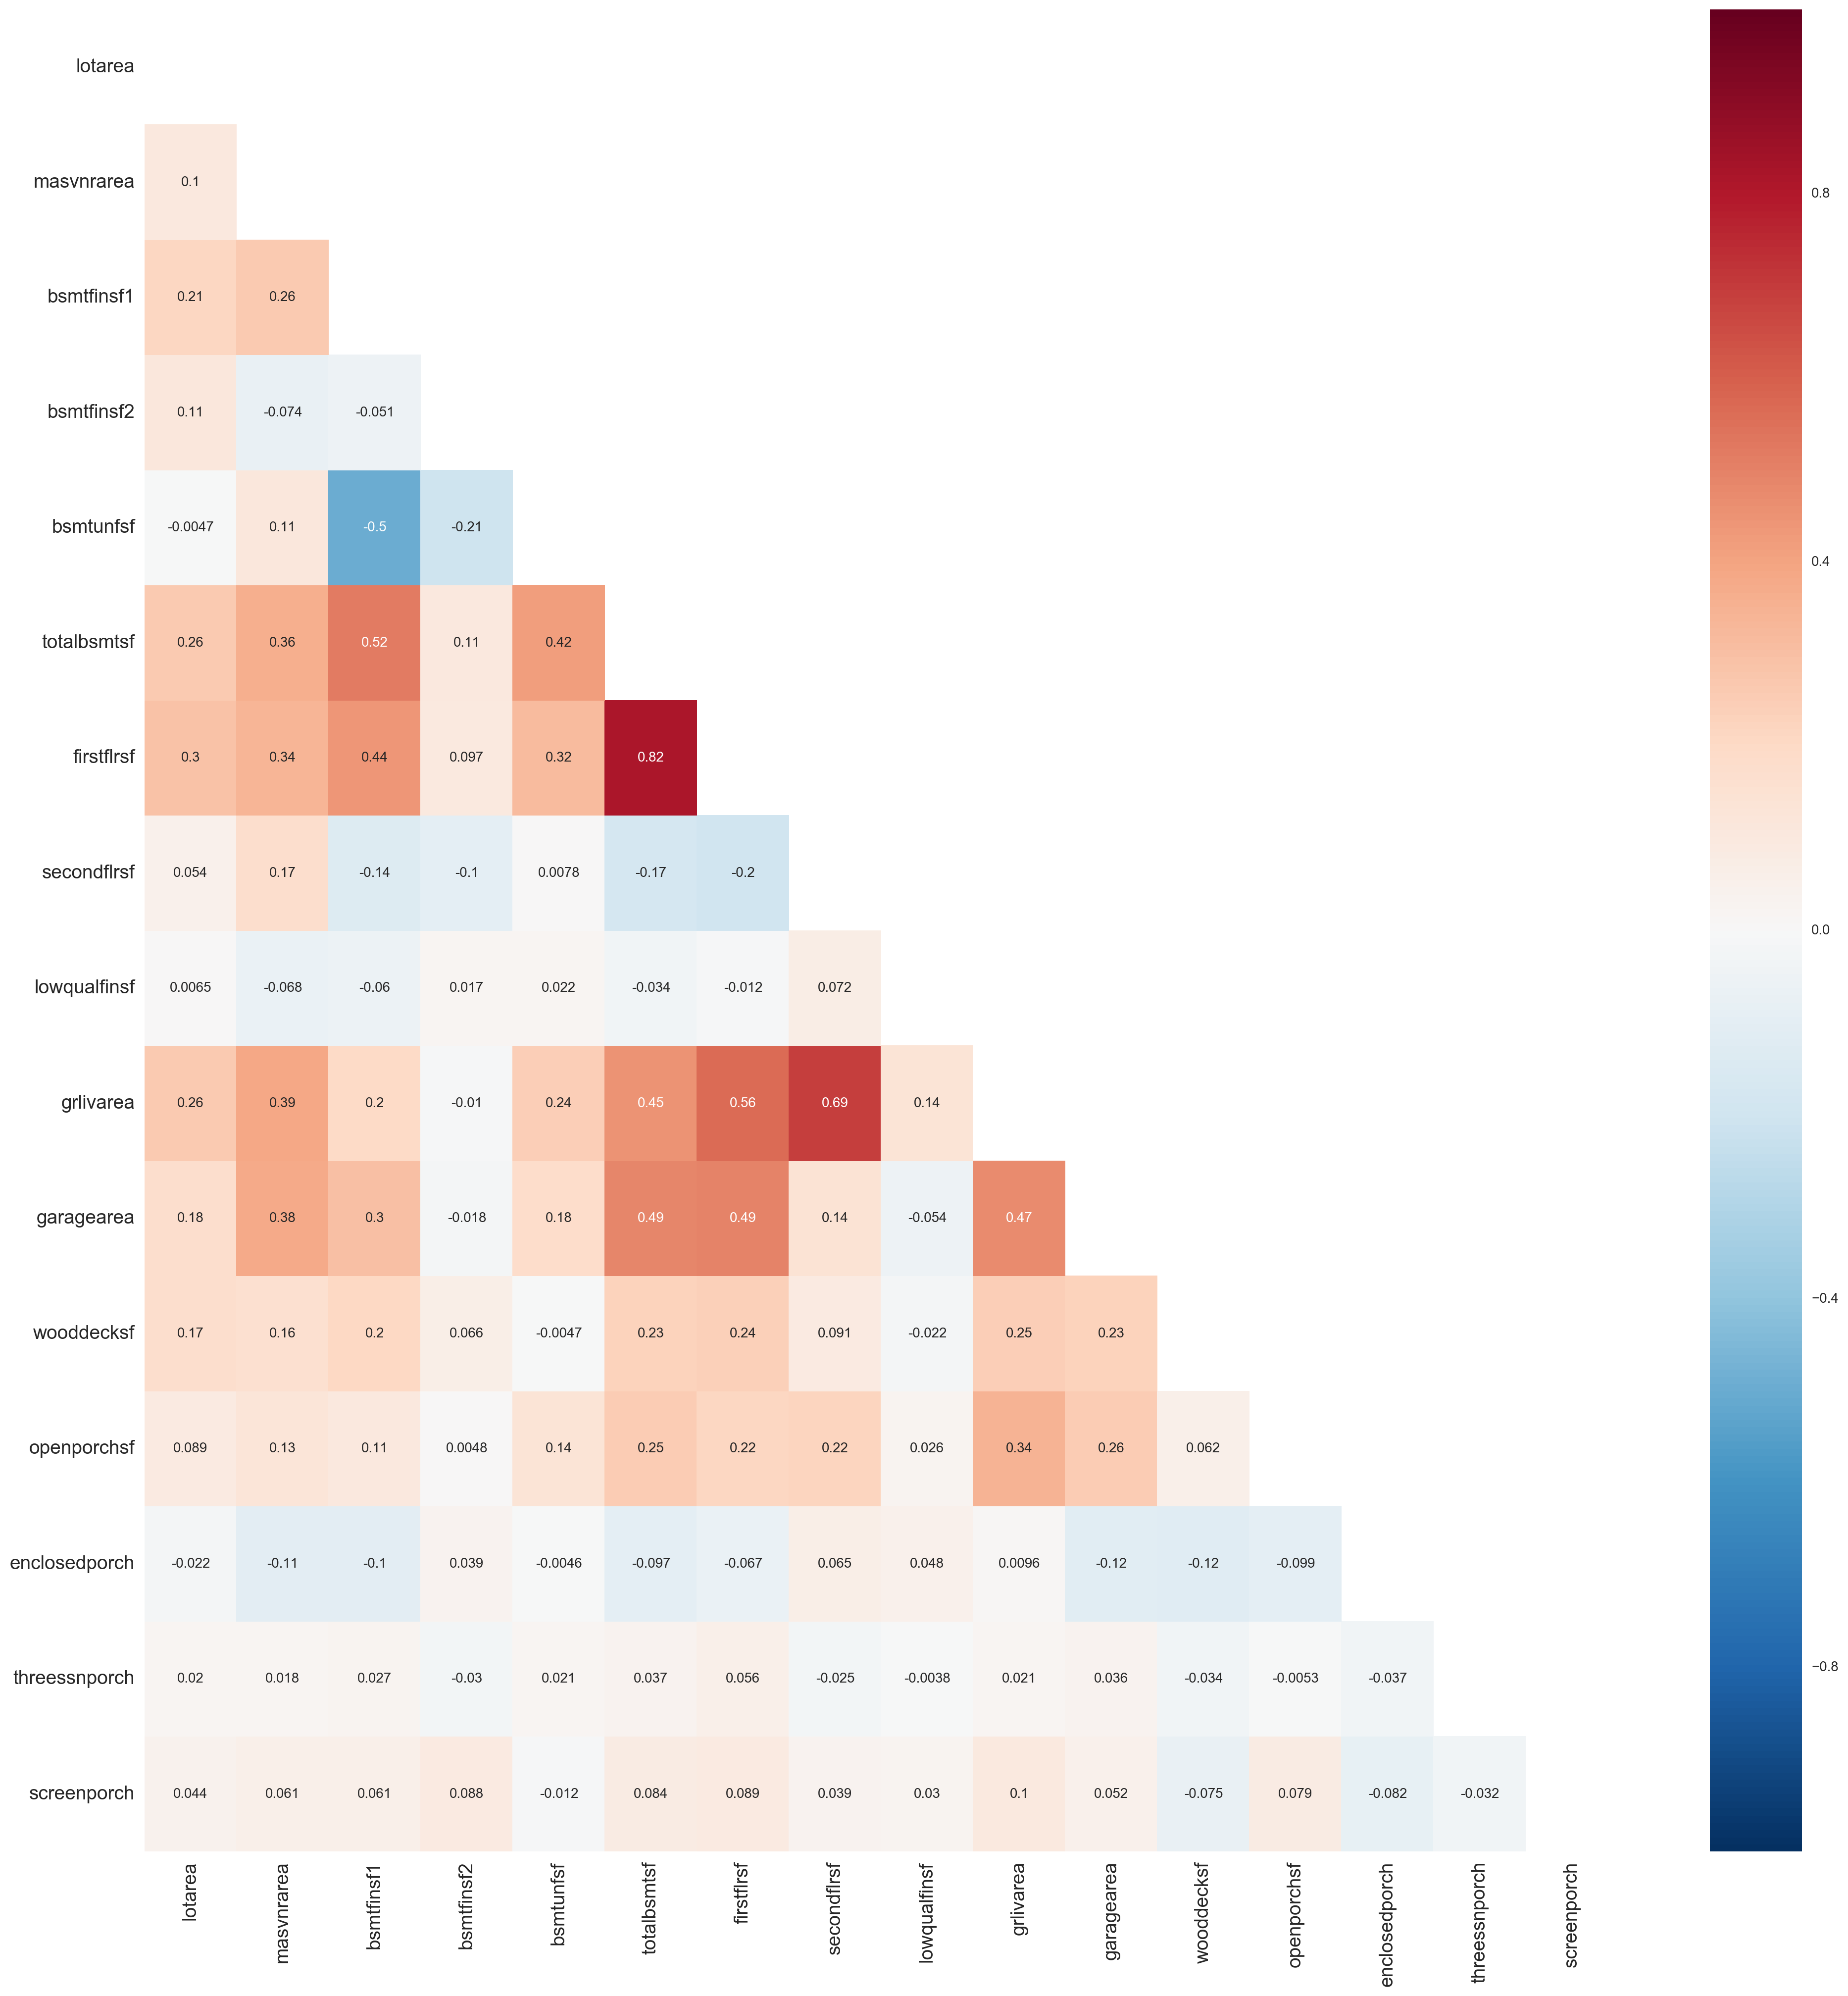

In [67]:
correlation_heat_map(sqf_related_predictors.astype('float'))

### 11.3 Find the optimal Ridge `alpha` using `RidgeCV'



In [68]:
from sklearn.preprocessing import StandardScaler

# Normalize the predictors before regularization
ss = StandardScaler()
X2n = ss.fit_transform(X2)

ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X2n, Y2)

print optimal_ridge.alpha_


ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X2n, Y2, cv=10)

print ridge_scores
print np.mean(ridge_scores)

243.744415012
[ 0.78935842  0.80027304  0.75861156  0.66792471  0.742238    0.76089015
  0.69651315  0.70811699  0.09473106  0.73892872]
0.675758579319


The cross-validated R^2 for the standard linear regression was negative indicating that the model failed to
predict random subsets of the data compared to baseline conditions. In contrast, the R^2 for the ridge regression is positive and closer to 1 than 0, indicating the ridge model better predicts the random subset of the data and is likely to be closer to the true model.

## 12. Differences between Ridge and Lasso regularization

Lasso regularization adds the absolute value of the beta coeffients to the objective function minimizing the sum of the squared loss, whereas Ridge regularization add thee squared value of the beta coefficients. 

In Lasso, the predictors that have a marginal effect on the target variable are nearly or entirely elminated, and those that have a strong effect remain have coefficients with a value representing the degree of the effect on the target. Therefore, Lasso regularization is good for feature selection, when there are many variables to select from a dataset.

The Ridge is good when the predictors are highly multicollinear. The coeffients for the mulitcollinear predictors are reduced, so that they share the variance of the target variable. This allows for multicollinear predictors to be used in regression modeling. 

## 13. Gridsearch an optimal `ElasticNet` regression

In [77]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 50), n_alphas=300, cv=10, verbose=1)
enet_cv.fit(Xn, Y)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0.01   ,  0.0302 ,  0.05041,  0.07061,  0.09082,  0.11102,
        0.13122,  0.15143,  0.17163,  0.19184,  0.21204,  0.23224,
        0.25245,  0.27265,  0.29286,  0.31306,  0.33327,  0.35347,
        0.37367,  0.39388,  0.41408,  0.43429,  0.45449,  0.47469,
        0.4949 ,  0.515...3837,
        0.85857,  0.87878,  0.89898,  0.91918,  0.93939,  0.95959,
        0.9798 ,  1.     ]),
       max_iter=1000, n_alphas=300, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=1)

In [78]:
print enet_cv.l1_ratio_
print enet_cv.alpha_

0.01
0.10360826097


The ElasticNet regression l1 ratio is closer to 0 than to 1, which indicates that the best regularization method is Lasso. 